In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
from numba import njit
from scipy.interpolate import BarycentricInterpolator
from itertools import product
from tqdm import tqdm
import plotly.express as px
from matplotlib.patches import Rectangle
#import plotly.graph_objects as go

In [2]:
def load_file(fp) :
    mi = np.fromfile(fp, dtype = '<u8')
    mat = np.zeros((mi.shape[0], 6), dtype = "u4") 
    mat[:,0] = mi & 31 # tdc, 0-4 (5)
    mat[:,1] = (mi & 131040) >> 5 # bx, 5-16 (12)
    mat[:,2] = (mi & 562949953290240) >> 17 # orbit, 17-48 (32)
    mat[:,3] = (mi & 287667426198290432) >> 49 # chan, 49-57 (9)
    mat[:,4] = (mi & 2017612633061982208) >> 58 # fpga (3)
    mat[:,5] = mi >> 61

    return mat

In [3]:
tipi = {'tdc':'u1', 'bx':'u2', 'orbit':'u4', 'chan':'u2', 'fpga':'u1', 'head':'u1'}

m = load_file('data/data_000000.dat')
df = pd.DataFrame(m, columns = ['tdc', 'bx', 'orbit', 'chan', 'fpga', 'head'])
df = df.astype(tipi)
df

,tdc,bx,orbit,chan,fpga,head
0,0,0,4079645633,100,1,1
1,2,4064,4079645602,100,1,0
2,23,1476,4079645568,100,1,4
3,16,653,4079645568,100,1,5
4,2,2922,3387200947,75,0,2
...,...,...,...,...,...,...
1310587,6,438,5797423,107,0,2
1310588,3,4092,741923455,0,0,0
1310589,18,339,741923328,0,0,4
1310590,8,1721,741923328,0,0,5


In [4]:
# rimuovo head diverso da 2
df = df[df['head'] == 2]
df

,tdc,bx,orbit,chan,fpga,head
4,2,2922,3387200947,75,0,2
5,29,2227,3387200955,105,0,2
6,7,2234,3387200955,107,0,2
7,29,476,3387200973,126,0,2
8,12,1797,3387200955,55,1,2
...,...,...,...,...,...,...
1310583,14,424,5797423,49,0,2
1310584,15,430,5797423,105,0,2
1310585,11,429,5797423,50,0,2
1310586,3,431,5797423,104,0,2


In [5]:
# tengo le orbite con 2 < n < 16 hits # prima per sbaglio avevo scritto 3 < n, ma in realtà per fare un fit sensato basta 2 < n (i.e. n >= 3, non > 3)
s = df.groupby('orbit').size()
s1 = s[(s > 2) & (s < 16)].index
df = df[df.orbit.isin(s1)]
df

,tdc,bx,orbit,chan,fpga,head
5,29,2227,3387200955,105,0,2
6,7,2234,3387200955,107,0,2
7,29,476,3387200973,126,0,2
8,12,1797,3387200955,55,1,2
11,28,475,3387200973,90,1,2
...,...,...,...,...,...,...
1310583,14,424,5797423,49,0,2
1310584,15,430,5797423,105,0,2
1310585,11,429,5797423,50,0,2
1310586,3,431,5797423,104,0,2


## Ai fini del fit globale dovremmo chiedere minimo 6 hits per orbita (minimo 3 * minimo 2 camere)
cfr caruso        

Per essere più precisi potremmo fare fin da subito pure il groupby eccetera, ma intanto meglio fare questa cosa più semplice e poi lasciarci per dopo questo check (specie perché dovrei distinguere fra camere uguali e diverse da 1, ecc.)

Nota: in teoria dovresti aggiungere +1 al numero minimo perché ancora non abbiamo tolto gli scintillatori

In [6]:
# troppa poca pazienza?
df1 = df#[:len(df)//100]
df1

,tdc,bx,orbit,chan,fpga,head
5,29,2227,3387200955,105,0,2
6,7,2234,3387200955,107,0,2
7,29,476,3387200973,126,0,2
8,12,1797,3387200955,55,1,2
11,28,475,3387200973,90,1,2
...,...,...,...,...,...,...
1310583,14,424,5797423,49,0,2
1310584,15,430,5797423,105,0,2
1310585,11,429,5797423,50,0,2
1310586,3,431,5797423,104,0,2


In [7]:
tipi

{'tdc': 'u1',
 'bx': 'u2',
 'orbit': 'u4',
 'chan': 'u2',
 'fpga': 'u1',
 'head': 'u1'}

In [8]:
def scintillatore(gruppo) :
    if ((gruppo['fpga'] == 1) & (gruppo['chan'] == 128)).any() :
        return gruppo
    else:
        return None

tipi = {'tdc':'u1', 'bx':'u2', 'orbit':'u4', 'chan':'u2', 'fpga':'u1', 'head':'u1'}
df2 = df1.groupby('orbit').apply(scintillatore).dropna().astype(tipi) # dopo apply casta tutto a float per essere compatibile con il None, credo. Per evitare un recast e risparmiare memoria si può usare una flag diversa da None/np.nan MA mi secco per un test del cavolo
df2

,tdc,bx,orbit,chan,fpga,head
6683,27,878,1118948,91,1,2
6687,8,882,1118948,107,0,2
6688,18,881,1118948,47,1,2
6689,12,884,1118948,88,1,2
6690,7,881,1118948,128,1,2
...,...,...,...,...,...,...
1304049,1,3551,5773565,41,1,2
1304050,8,3552,5773565,36,1,2
1304051,6,3558,5773565,38,1,2
1304056,4,3544,5773565,120,0,2


In [9]:
# tempi
df2['t'] = 25*df2['bx'] + 25*df2['tdc']/30
df2

,tdc,bx,orbit,chan,fpga,head,t
6683,27,878,1118948,91,1,2,21955.433333
6687,8,882,1118948,107,0,2,22056.666667
6688,18,881,1118948,47,1,2,22031.466667
6689,12,884,1118948,88,1,2,22101.466667
6690,7,881,1118948,128,1,2,22030.833333
...,...,...,...,...,...,...,...
1304049,1,3551,5773565,41,1,2,23239.833333
1304050,8,3552,5773565,36,1,2,23270.666667
1304051,6,3558,5773565,38,1,2,23419.000000
1304056,4,3544,5773565,120,0,2,23067.333333


In [10]:
# rimuovo le orbite con più scintillatori
v1, v2 = np.unique(df2.loc[df2.chan == 128, 'orbit'], return_counts = True)
df2.loc[df2.orbit.isin(v1[v2 > 1])] = None
df2 = df2.dropna().astype(tipi)
df2

,tdc,bx,orbit,chan,fpga,head,t
6683,27,878,1118948,91,1,2,21955.433333
6687,8,882,1118948,107,0,2,22056.666667
6688,18,881,1118948,47,1,2,22031.466667
6689,12,884,1118948,88,1,2,22101.466667
6690,7,881,1118948,128,1,2,22030.833333
...,...,...,...,...,...,...,...
1304049,1,3551,5773565,41,1,2,23239.833333
1304050,8,3552,5773565,36,1,2,23270.666667
1304051,6,3558,5773565,38,1,2,23419.000000
1304056,4,3544,5773565,120,0,2,23067.333333


In [11]:
# def time_pedestal(gruppo) :
#     gruppo.loc['t0'] = gruppo.loc[gruppo['chan'] == 128, 't0'].values # questa cosa funziona solo se c'è un unico scintillatore per orbita, cfr cella sopra
#     return gruppo

#df2['t0'] = None
#df2 = df2.groupby('orbit').apply(time_pedestal) # non gli piace
s = df2.loc[df2['chan'] == 128, ['orbit', 't']].set_index('orbit')
df2['t0'] = s.loc[df2.orbit].t.to_numpy()
#s.loc[s.index == df2.orbit.unique()] # non mi serve

df2

,tdc,bx,orbit,chan,fpga,head,t,t0
6683,27,878,1118948,91,1,2,21955.433333,22030.833333
6687,8,882,1118948,107,0,2,22056.666667,22030.833333
6688,18,881,1118948,47,1,2,22031.466667,22030.833333
6689,12,884,1118948,88,1,2,22101.466667,22030.833333
6690,7,881,1118948,128,1,2,22030.833333,22030.833333
...,...,...,...,...,...,...,...,...
1304049,1,3551,5773565,41,1,2,23239.833333,22991.300000
1304050,8,3552,5773565,36,1,2,23270.666667,22991.300000
1304051,6,3558,5773565,38,1,2,23419.000000,22991.300000
1304056,4,3544,5773565,120,0,2,23067.333333,22991.300000


In [12]:
df2.iloc[:20] # tutto ok

,tdc,bx,orbit,chan,fpga,head,t,t0
6683,27,878,1118948,91,1,2,21955.433333,22030.833333
6687,8,882,1118948,107,0,2,22056.666667,22030.833333
6688,18,881,1118948,47,1,2,22031.466667,22030.833333
6689,12,884,1118948,88,1,2,22101.466667,22030.833333
6690,7,881,1118948,128,1,2,22030.833333,22030.833333
6691,14,881,1118948,44,1,2,22028.133333,22030.833333
6692,17,883,1118948,90,1,2,22080.633333,22030.833333
6693,1,891,1118948,138,1,2,22275.833333,22030.833333
6694,5,887,1118948,46,1,2,22179.166667,22030.833333
6695,12,889,1118948,89,1,2,22226.466667,22030.833333


In [13]:
# rimuovo gli scintillatori, che non possono essere piazzati in nessuna colonna in particolare
# NON SOLO QUELLI! Ci sono canali spuri ancora al di sopra
#df2.loc[df2['chan'] == 128] = None  # non basta
df2.loc[df2['chan'] > 127] = None 
df2.dropna(inplace = True)

# alternativa dask-safe e probabilmente più efficiente: df2 = df2[df2['chan] < 128]

df2 = df2.astype(tipi)
df2

,tdc,bx,orbit,chan,fpga,head,t,t0
6683,27,878,1118948,91,1,2,21955.433333,22030.833333
6687,8,882,1118948,107,0,2,22056.666667,22030.833333
6688,18,881,1118948,47,1,2,22031.466667,22030.833333
6689,12,884,1118948,88,1,2,22101.466667,22030.833333
6691,14,881,1118948,44,1,2,22028.133333,22030.833333
...,...,...,...,...,...,...,...,...
1304049,1,3551,5773565,41,1,2,23239.833333,22991.300000
1304050,8,3552,5773565,36,1,2,23270.666667,22991.300000
1304051,6,3558,5773565,38,1,2,23419.000000,22991.300000
1304056,4,3544,5773565,120,0,2,23067.333333,22991.300000


In [14]:
# assegno la camera
df2['chamber'] = 23 # un numero a caso che però non è None (che non "entra" in un intero)

df2.loc[(df2['fpga'] == 0) & (df2['chan'] < 64), 'chamber'] = 0
df2.loc[(df2['fpga'] == 0) & (df2['chan'] > 63), 'chamber'] = 1
df2.loc[(df2['fpga'] == 1) & (df2['chan'] < 64), 'chamber'] = 2
df2.loc[(df2['fpga'] == 1) & (df2['chan'] > 63), 'chamber'] = 3

# assegno il layer
# layer: facciamo che contiamo da 0 a 3 partendo dal basso
df2['layer'] = df2['chan'] % 4
df2['layer'].replace({0:3, 3:0}, inplace = True) # 2:2, 1:1

# resetto/aggiorno i tipi
tipi2 = tipi
tipi2['chamber'] = 'u1'
tipi2['layer'] = 'u1'
df2 = df2.astype(tipi2)

df2

,tdc,bx,orbit,chan,fpga,head,t,t0,chamber,layer
6683,27,878,1118948,91,1,2,21955.433333,22030.833333,3,0
6687,8,882,1118948,107,0,2,22056.666667,22030.833333,1,0
6688,18,881,1118948,47,1,2,22031.466667,22030.833333,2,0
6689,12,884,1118948,88,1,2,22101.466667,22030.833333,3,3
6691,14,881,1118948,44,1,2,22028.133333,22030.833333,2,3
...,...,...,...,...,...,...,...,...,...,...
1304049,1,3551,5773565,41,1,2,23239.833333,22991.300000,2,1
1304050,8,3552,5773565,36,1,2,23270.666667,22991.300000,2,3
1304051,6,3558,5773565,38,1,2,23419.000000,22991.300000,2,2
1304056,4,3544,5773565,120,0,2,23067.333333,22991.300000,1,3


In [15]:
def numero_di_chambers(gruppo) :
    if gruppo.nunique()['chamber'] > 1 : # sapendo che tecnicamente questo riguarda comunque solo le camere diverse da 1
        return gruppo
    else :
        return None 

df2 = df2.groupby('orbit').apply(numero_di_chambers).dropna().astype(tipi2)
df2

,tdc,bx,orbit,chan,fpga,head,t,t0,chamber,layer
6683,27,878,1118948,91,1,2,21955.433333,22030.833333,3,0
6687,8,882,1118948,107,0,2,22056.666667,22030.833333,1,0
6688,18,881,1118948,47,1,2,22031.466667,22030.833333,2,0
6689,12,884,1118948,88,1,2,22101.466667,22030.833333,3,3
6691,14,881,1118948,44,1,2,22028.133333,22030.833333,2,3
...,...,...,...,...,...,...,...,...,...,...
1304049,1,3551,5773565,41,1,2,23239.833333,22991.300000,2,1
1304050,8,3552,5773565,36,1,2,23270.666667,22991.300000,2,3
1304051,6,3558,5773565,38,1,2,23419.000000,22991.300000,2,2
1304056,4,3544,5773565,120,0,2,23067.333333,22991.300000,1,3


In [16]:
#pd.DataFrame(df2.groupby(['orbit', 'chamber']).nunique()['layer'])

In [17]:
# tolgo eventi (groupby orbit and chamber) con meno di 3 eventi (un fit con 2 punti non ha senso, e ho già tolto gli scintillatori)
#df2 = df2[df2.groupby(['orbit', 'chamber']).nunique()['layer'] > 2] #questa riga può funzionare solo se df2 ha come index [orbit, chamber] se no c'è un mismatch nel tipo di indici!!

def numero_di_layers(gruppo):
    if gruppo.nunique()['layer'] > 2 :
        return gruppo
    else :
        return None

df2backup = df2.copy()
#df2 = df2backup.copy()

df2 = df2.groupby(['orbit', 'chamber']).apply(numero_di_layers).dropna().reset_index(drop = True).astype(tipi2) # senza drop = True in reset index dà errore
df2 # passano quasi tutti

,tdc,bx,orbit,chan,fpga,head,t,t0,chamber,layer
0,8,882,1118948,107,0,2,22056.666667,22030.833333,1,0
1,20,890,1118948,105,0,2,22258.133333,22030.833333,1,1
2,13,891,1118948,108,0,2,22277.300000,22030.833333,1,3
3,18,881,1118948,47,1,2,22031.466667,22030.833333,2,0
4,14,881,1118948,44,1,2,22028.133333,22030.833333,2,3
...,...,...,...,...,...,...,...,...,...,...
4358,30,3537,5773565,39,1,2,22896.933333,22991.300000,2,0
4359,25,3538,5773565,38,1,2,22917.766667,22991.300000,2,2
4360,1,3551,5773565,41,1,2,23239.833333,22991.300000,2,1
4361,8,3552,5773565,36,1,2,23270.666667,22991.300000,2,3


In [18]:
a1, a2 = np.unique(df2backup.iloc[:11]['chamber'], return_counts = True)
print(a1, a2) # non è un esempio buono lol ma mi secco a cercarne uno

[1 2 3] [3 4 4]


In [19]:
b1, b2 = np.unique(df2.iloc[:11]['chamber'], return_counts = True)
print(b1, b2) # inutile

[1 2 3] [3 4 4]


In [20]:
# # perché il fit funzioni devo togliere gli eventi con troppe hits sullo stesso layer
# # def stesso_layer(gruppo) :
# #     if len(gruppo['layer'].unique()) == 

# # stessa idea ma senza apply
# df2 = df2.set_index(['orbit', 'chamber'])
# #df2 = df2[df2.groupby(['orbit', 'chamber']).size() == df.groupby(['orbit', 'chamber']).nunique()["layer"]] # oppure vai di set_index() e qui usi groupby(df2.index), come fatto per Zanetti
# # stesso commento di prima: questa riga può funzionare solo se df2 ha come index [orbit, chamber] se no c'è un mismatch nel tipo di indici!!

# df2 = df2[df2.groupby(df2.index).size() == df.groupby(df2.index).nunique()["layer"]].reset_index(drop = True).astype(tipi2)
# # credo sia più efficiente fare un set index una tantum e poi groupby per index, che dovrebbe essere più efficiente rispetto alle altre colonne
# # tuttavia non ne sono sicuro, comunque bisognerebbe fare la prova. cfr https://docs.dask.org/en/latest/dataframe.html

# # è anche vero che qui non sto facendo groupby + apply... boh
# df2

In [21]:
# non funziona niente qua sopra, facciamo alla vecchia maniera
def stesso_layer(gruppo) :
    if gruppo['layer'].nunique() == len(gruppo) :
        return gruppo
    else :
        return None 
    
df2 = df2.groupby(['orbit', 'chamber']).apply(stesso_layer).dropna().reset_index(drop = True).astype(tipi2)
df2

,tdc,bx,orbit,chan,fpga,head,t,t0,chamber,layer
0,8,882,1118948,107,0,2,22056.666667,22030.833333,1,0
1,20,890,1118948,105,0,2,22258.133333,22030.833333,1,1
2,13,891,1118948,108,0,2,22277.300000,22030.833333,1,3
3,18,881,1118948,47,1,2,22031.466667,22030.833333,2,0
4,14,881,1118948,44,1,2,22028.133333,22030.833333,2,3
...,...,...,...,...,...,...,...,...,...,...
3208,17,1041,5762142,40,1,2,26030.633333,25777.100000,2,3
3209,28,3539,5773565,119,0,2,22945.266667,22991.300000,1,0
3210,11,3545,5773565,118,0,2,23089.633333,22991.300000,1,2
3211,4,3544,5773565,120,0,2,23067.333333,22991.300000,1,3


In [22]:
# ok no, recupero la convenzione che contiamo da 1 per pigrizia (sia tdc che layer)
# COME NON DETTO; GEOMETRIA TROPPO DIFFERENTE, DEVO RIVEDERE I CONTI IN OGNI CASO!

# In ogni caso PURE PER LORO LAYER VA DA 1 IN BASSO A 4 IN ALTO!!
df3 = df2.copy()

df3['layer'] += 1
# df3['chan'] += 1
# df3.loc[df3["chan"] > 64,"chan"] -= 64 

# f = BarycentricInterpolator([1,2,3,4],[0,2,1,3])

# df3["column"] = ((df3['chan'] + f(df3["layer"])) / 4).astype(np.uint8)

df3.loc[df3["chan"] > 63,"chan"] -= 64

f = BarycentricInterpolator([1,2,3,4],[1,3,2,4])
df3["column"] = ((df3['chan'] + f(df3["layer"])) / 4).astype(np.uint8)
df3

,tdc,bx,orbit,chan,fpga,head,t,t0,chamber,layer,column
0,8,882,1118948,43,0,2,22056.666667,22030.833333,1,1,11
1,20,890,1118948,41,0,2,22258.133333,22030.833333,1,2,11
2,13,891,1118948,44,0,2,22277.300000,22030.833333,1,4,12
3,18,881,1118948,47,1,2,22031.466667,22030.833333,2,1,12
4,14,881,1118948,44,1,2,22028.133333,22030.833333,2,4,12
...,...,...,...,...,...,...,...,...,...,...,...
3208,17,1041,5762142,40,1,2,26030.633333,25777.100000,2,4,11
3209,28,3539,5773565,55,0,2,22945.266667,22991.300000,1,1,14
3210,11,3545,5773565,54,0,2,23089.633333,22991.300000,1,3,14
3211,4,3544,5773565,56,0,2,23067.333333,22991.300000,1,4,15


In [23]:
df3.column.max() # ora va bene (se tolgo tutti i canali sopra il 127)

16

In [24]:
# df3["column"] = ((df3['chan'] + f(df3["layer"])) / 4).astype(np.uint8) # questa lettura fallisce se lasci gli scintillatori, che hanno chan 64 e quindi ricevono col == 17
# print(df3['column'].max())

In [25]:
# roba vecchia:
# #np.arange(1,33,2): centers in the first layers have coordinates: dx*1/2, dx+dx*1/2=dx*3/2, dx+dx*3/2=dx*5/2,... Therefore in dx/2 units our coordinates are: 1,3,5,... i.e. odd numbers up to (16-1/2)*dx=31*(dx/2);we can hence use np.arange() with 33 as second argument since stop is not included.
# #np.arange(2,34,2): the second layer behaves exactly like the first but with a dx/2 horizontal shift i.e. 1 in dx/2 units. We can also use np.arange(1,33,2)+1, which easier to understand but not really necessary

# centers_coords = np.vstack((np.arange(1,33,2),np.arange(2,34,2))) #2 rows corresponding to the first 2 layers
# centers_coords = np.vstack((centers_coords,centers_coords)) #layer 3 and 4 are a copy of 1 & 2

# df["CENTER"] = centers_coords[df.LAYER-1,df.COLUMN-1] #-1 is needed to fix different conventions (i.e. whether we count from 0 or 1)
# df #To check whether the result is correct notice that if layer is even then center = column*2, otherwise center = column*2-1


centers_coords = np.vstack((np.arange(2,34,2),np.arange(1,33,2))) # ok. invertito è giusto come deve essere, ho fatto un check con le prime righe/colonne
centers_coords = np.vstack((centers_coords,centers_coords))
print(centers_coords)

df3["center"] = centers_coords[df3.layer-1,df3.column-1] 
df3 #To check whether the result is correct notice that if layer is even then center = column*2, otherwise center = column*2-1

[[ 2  4  6  8 10 12 14 16 18 20 22 24 26 28 30 32]
 [ 1  3  5  7  9 11 13 15 17 19 21 23 25 27 29 31]
 [ 2  4  6  8 10 12 14 16 18 20 22 24 26 28 30 32]
 [ 1  3  5  7  9 11 13 15 17 19 21 23 25 27 29 31]]


,tdc,bx,orbit,chan,fpga,head,t,t0,chamber,layer,column,center
0,8,882,1118948,43,0,2,22056.666667,22030.833333,1,1,11,22
1,20,890,1118948,41,0,2,22258.133333,22030.833333,1,2,11,21
2,13,891,1118948,44,0,2,22277.300000,22030.833333,1,4,12,23
3,18,881,1118948,47,1,2,22031.466667,22030.833333,2,1,12,24
4,14,881,1118948,44,1,2,22028.133333,22030.833333,2,4,12,23
...,...,...,...,...,...,...,...,...,...,...,...,...
3208,17,1041,5762142,40,1,2,26030.633333,25777.100000,2,4,11,21
3209,28,3539,5773565,55,0,2,22945.266667,22991.300000,1,1,14,28
3210,11,3545,5773565,54,0,2,23089.633333,22991.300000,1,3,14,28
3211,4,3544,5773565,56,0,2,23067.333333,22991.300000,1,4,15,29


In [26]:
time_offset = np.array([-1.1, 6.4, 0.5, -2.6])

# l'offset è PER CHAMBER, sia per dt che per z!!!

df3['dt'] = df3['t'] - df3['t0'] + 95 + time_offset[df3['chamber']] # chamber va da 0
df3

,tdc,bx,orbit,chan,fpga,head,t,t0,chamber,layer,column,center,dt
0,8,882,1118948,43,0,2,22056.666667,22030.833333,1,1,11,22,127.233333
1,20,890,1118948,41,0,2,22258.133333,22030.833333,1,2,11,21,328.700000
2,13,891,1118948,44,0,2,22277.300000,22030.833333,1,4,12,23,347.866667
3,18,881,1118948,47,1,2,22031.466667,22030.833333,2,1,12,24,96.133333
4,14,881,1118948,44,1,2,22028.133333,22030.833333,2,4,12,23,92.800000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3208,17,1041,5762142,40,1,2,26030.633333,25777.100000,2,4,11,21,349.033333
3209,28,3539,5773565,55,0,2,22945.266667,22991.300000,1,1,14,28,55.366667
3210,11,3545,5773565,54,0,2,23089.633333,22991.300000,1,3,14,28,199.733333
3211,4,3544,5773565,56,0,2,23067.333333,22991.300000,1,4,15,29,177.433333


In [27]:
print(np.count_nonzero(df3.dt > 0)/len(df3)*100)

99.2530345471522


In [28]:
T = 21/53.8e-3
print(T)
print(len(df3[df3.dt < T]))
print(len(df3[(df3.dt < T) & (df3.dt > 0)]))

390.3345724907063
3160
3136


**Importantissimi i filtri temporali!!**
- devo imporre che $\Delta t$ non superi il massimo valore (dato da $v_d$ diviso la semilunghezza di una cella, cioè 21 mm). Altrimenti possono spuntare eventi fuori dal detector, ad esempio, che sballano completamente i residui!!
- devo imporre $\Delta t > 0$. è possibile che quelli con $\Delta t$ negativo presi in modulo siano ancora buoni, ma siccome a) non lo so e b) sono pochi tanto vale buttarli.

Insomma la prossima cella è importantissima

In [29]:
df3 = df3[(df3.dt < T) & (df3.dt > 0)]
df3

,tdc,bx,orbit,chan,fpga,head,t,t0,chamber,layer,column,center,dt
0,8,882,1118948,43,0,2,22056.666667,22030.833333,1,1,11,22,127.233333
1,20,890,1118948,41,0,2,22258.133333,22030.833333,1,2,11,21,328.700000
2,13,891,1118948,44,0,2,22277.300000,22030.833333,1,4,12,23,347.866667
3,18,881,1118948,47,1,2,22031.466667,22030.833333,2,1,12,24,96.133333
4,14,881,1118948,44,1,2,22028.133333,22030.833333,2,4,12,23,92.800000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3208,17,1041,5762142,40,1,2,26030.633333,25777.100000,2,4,11,21,349.033333
3209,28,3539,5773565,55,0,2,22945.266667,22991.300000,1,1,14,28,55.366667
3210,11,3545,5773565,54,0,2,23089.633333,22991.300000,1,3,14,28,199.733333
3211,4,3544,5773565,56,0,2,23067.333333,22991.300000,1,4,15,29,177.433333


Da notare che COME TUTTI I FILTRI IN CUI TOLGO SINGOLE RIGHE POTENZIALMENTE LASCIANDO L'ORBITA DEVO RI-ASSICURARMI DI AVERE IL CORRETTO NUMERO MINIMO DI HITS!!

In [30]:
# nota per dask: sto usando filter qui solo perché sono pigro (così non devo rifare dropna e astype ecc.), ma si può benissimo usare apply + la stessa funzione di prima (numero di layers)
df3 = df3.groupby(['orbit', 'chamber']).filter(lambda gruppo: gruppo.nunique()['layer'] > 2) # filtro locale nello spazio e nel tempo --> raggruppo per orbit e chamber
df3

,tdc,bx,orbit,chan,fpga,head,t,t0,chamber,layer,column,center,dt
0,8,882,1118948,43,0,2,22056.666667,22030.833333,1,1,11,22,127.233333
1,20,890,1118948,41,0,2,22258.133333,22030.833333,1,2,11,21,328.700000
2,13,891,1118948,44,0,2,22277.300000,22030.833333,1,4,12,23,347.866667
3,18,881,1118948,47,1,2,22031.466667,22030.833333,2,1,12,24,96.133333
4,14,881,1118948,44,1,2,22028.133333,22030.833333,2,4,12,23,92.800000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3208,17,1041,5762142,40,1,2,26030.633333,25777.100000,2,4,11,21,349.033333
3209,28,3539,5773565,55,0,2,22945.266667,22991.300000,1,1,14,28,55.366667
3210,11,3545,5773565,54,0,2,23089.633333,22991.300000,1,3,14,28,199.733333
3211,4,3544,5773565,56,0,2,23067.333333,22991.300000,1,4,15,29,177.433333


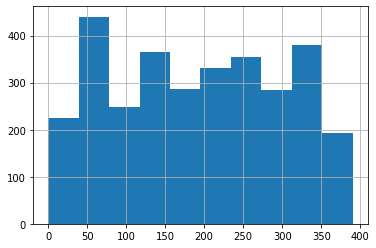

In [31]:
df3['dt'].hist();

In [32]:
# faccio un po' di pulizia un momento
df4 = df3.copy()[['orbit', 'chamber', 'layer', 'center', 'dt']]
df4

,orbit,chamber,layer,center,dt
0,1118948,1,1,22,127.233333
1,1118948,1,2,21,328.700000
2,1118948,1,4,23,347.866667
3,1118948,2,1,24,96.133333
4,1118948,2,4,23,92.800000
...,...,...,...,...,...
3208,5762142,2,4,21,349.033333
3209,5773565,1,1,28,55.366667
3210,5773565,1,3,28,199.733333
3211,5773565,1,4,29,177.433333


In [33]:
# 42/2 = 21
vd = 53.8*1e-3 # v_drift = 53.8 um/ns, voglio lavorare con i millimetri
df4['xr'] = df4['center']*21 + vd*df4['dt']
df4['xl'] = df4['center']*21 - vd*df4['dt']
df4

,orbit,chamber,layer,center,dt,xr,xl
0,1118948,1,1,22,127.233333,468.845153,455.154847
1,1118948,1,2,21,328.700000,458.684060,423.315940
2,1118948,1,4,23,347.866667,501.715227,464.284773
3,1118948,2,1,24,96.133333,509.171973,498.828027
4,1118948,2,4,23,92.800000,487.992640,478.007360
...,...,...,...,...,...,...,...
3208,5762142,2,4,21,349.033333,459.777993,422.222007
3209,5773565,1,1,28,55.366667,590.978727,585.021273
3210,5773565,1,3,28,199.733333,598.745653,577.254347
3211,5773565,1,4,29,177.433333,618.545913,599.454087


In [34]:
z_offset = np.array([219.8, 977.3, 1035.6, 1819.8])
# dz2 = 13/2

# l'offset è PER CHAMBER, sia per dt che per z!!!

# df4['z'] = df4['layer']*dz2 + z_offset[df4['chamber']] # ERRORISSIMO DA SISTEMARE!
dz = 13
df4['z'] = (df4['layer'] - 0.5)*dz + z_offset[df4['chamber']] # altezza dei 4 layer: 1/2*dz, 3/2*dz, 5/2*dz, 7/2*dz (tutti valori uguali a layer - 1/2). cfr Zanetti, ad es.
df4

,orbit,chamber,layer,center,dt,xr,xl,z
0,1118948,1,1,22,127.233333,468.845153,455.154847,983.8
1,1118948,1,2,21,328.700000,458.684060,423.315940,996.8
2,1118948,1,4,23,347.866667,501.715227,464.284773,1022.8
3,1118948,2,1,24,96.133333,509.171973,498.828027,1042.1
4,1118948,2,4,23,92.800000,487.992640,478.007360,1081.1
...,...,...,...,...,...,...,...,...
3208,5762142,2,4,21,349.033333,459.777993,422.222007,1081.1
3209,5773565,1,1,28,55.366667,590.978727,585.021273,983.8
3210,5773565,1,3,28,199.733333,598.745653,577.254347,1009.8
3211,5773565,1,4,29,177.433333,618.545913,599.454087,1022.8


In [35]:
z_offset[1]+13/2

983.8

In [36]:
c = df4[(df4.orbit == df4.orbit.iloc[0]) & (df4.chamber == 3)]
c

,orbit,chamber,layer,center,dt,xr,xl,z
7,1118948,3,1,14,17.000000,294.914600,293.085400,1826.3
8,1118948,3,4,13,163.033333,281.771193,264.228807,1865.3
9,1118948,3,3,14,142.200000,301.650360,286.349640,1852.3
10,1118948,3,2,13,288.033333,288.496193,257.503807,1839.3


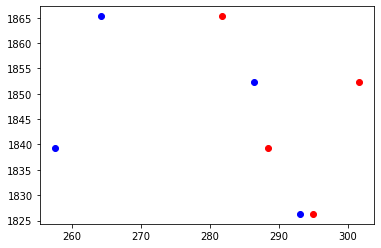

In [37]:
plt.scatter(c.xr, c.z, c = "red")
plt.scatter(c.xl, c.z, c = "blue");

In [38]:
# @njit 
# def numba_score(combin,eventZ) :
#     s = np.zeros(combin.shape[0]) 
#     for i, c in enumerate(combin) :
#         if ((eventZ - eventZ.mean())**2).sum() == 0 : # dice che se no ci sono delle divisioni per zero anche se non riesco a riprodurle a mano... assurdo
#             s[i] = 0 #np.nan
#         else :
#             slope = ((eventZ - eventZ.mean())*(c - c.mean())).sum() / ((eventZ - eventZ.mean())**2).sum()
#             intercept = c.mean() - slope*eventZ.mean() # cfr https://en.wikipedia.org/wiki/Simple_linear_regression con x e y scambiati

#             s[i] = np.linalg.norm(c - (slope*eventZ+intercept))
#     return s

# ok, credo che servisse quel protector per compensare la mancanza del filtro che rimuove eventi con più celle attive nello stesso layer
@njit 
def numba_score(combin,eventZ) :
    s = np.zeros(combin.shape[0]) 
    for i, c in enumerate(combin) :
        slope = ((eventZ - eventZ.mean())*(c - c.mean())).sum() / ((eventZ - eventZ.mean())**2).sum()
        intercept = c.mean() - slope*eventZ.mean() # cfr https://en.wikipedia.org/wiki/Simple_linear_regression con x e y scambiati

        s[i] = np.linalg.norm(c - (slope*eventZ+intercept))
    return s




def solve_ambiguity(event):
    combin = np.array(list(product(*event.loc[:, ['xr','xl']].to_numpy())))
    s = numba_score(combin,event.z.to_numpy())
    event['xb'] = combin[s.argmin()]
    return event

In [39]:
# df2 = df2.reset_index().groupby(["ORBIT_CNT","EVENT"], group_keys=False).apply(solve_ambiguity2) #reset_index() is needed to make this work
# df2 = df2.set_index(["ORBIT_CNT","EVENT"])
# df2
c = c.groupby(['orbit', 'chamber']).apply(solve_ambiguity) # tutto va fatto localmente per ora (sia nello spazio che nel tempo!)
c

,orbit,chamber,layer,center,dt,xr,xl,z,xb
7,1118948,3,1,14,17.000000,294.914600,293.085400,1826.3,293.085400
8,1118948,3,4,13,163.033333,281.771193,264.228807,1865.3,281.771193
9,1118948,3,3,14,142.200000,301.650360,286.349640,1852.3,286.349640
10,1118948,3,2,13,288.033333,288.496193,257.503807,1839.3,288.496193


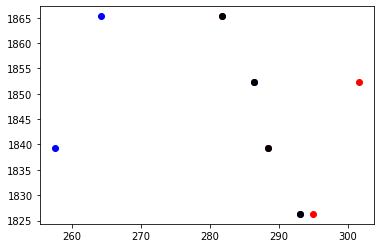

In [40]:
plt.scatter(c.xr, c.z, c = "red")
plt.scatter(c.xl, c.z, c = "blue")
plt.scatter(c.xb, c.z, c = "black");

In [41]:
df5 = df4.copy()
df5 = df5.groupby(['orbit', 'chamber']).apply(solve_ambiguity)
df5

,orbit,chamber,layer,center,dt,xr,xl,z,xb
0,1118948,1,1,22,127.233333,468.845153,455.154847,983.8,455.154847
1,1118948,1,2,21,328.700000,458.684060,423.315940,996.8,458.684060
2,1118948,1,4,23,347.866667,501.715227,464.284773,1022.8,464.284773
3,1118948,2,1,24,96.133333,509.171973,498.828027,1042.1,498.828027
4,1118948,2,4,23,92.800000,487.992640,478.007360,1081.1,487.992640
...,...,...,...,...,...,...,...,...,...
3208,5762142,2,4,21,349.033333,459.777993,422.222007,1081.1,459.777993
3209,5773565,1,1,28,55.366667,590.978727,585.021273,983.8,590.978727
3210,5773565,1,3,28,199.733333,598.745653,577.254347,1009.8,598.745653
3211,5773565,1,4,29,177.433333,618.545913,599.454087,1022.8,599.454087


In [42]:
# for index, subframe in tqdm(df4.groupby(['orbit', 'chamber'])) :
#    display(solve_ambiguity(subframe))

In [43]:
# ve = df4.loc[df4.orbit == df4.orbit.unique()[35]].sort_values('chamber').z.to_numpy().reshape((-1,4))
# ve

In [44]:
# for i in range(3) :
#     print(((ve[i] - ve[i].mean())**2).sum())

In [45]:
# df5.loc[df5.orbit == df5.orbit.unique()[35]]

In [46]:
# tutti questi sort non mi servono, ma non fa niente perché questa cella era solo un test (infatti ha un hardcoding che fa schifo! Orbita 35: 4 eventi per camera, 3 camere)
# quanto scritto qua sopra valeva solo quando per sbaglio all'inizio c'era < 15 anziché < 16

# vxr = df5.loc[df5.orbit == df5.orbit.unique()[35]].sort_values('chamber').xr.to_numpy().reshape((-1, 4))
# vxl = df5.loc[df5.orbit == df5.orbit.unique()[35]].sort_values('chamber').xl.to_numpy().reshape((-1, 4))
# vxb = df5.loc[df5.orbit == df5.orbit.unique()[35]].sort_values('chamber').xb.to_numpy().reshape((-1, 4))
# vz = df5.loc[df5.orbit == df5.orbit.unique()[35]].sort_values('chamber').z.to_numpy().reshape((-1, 4))
# for i in range(3) :
#     fig, ax = plt.subplots()
#     ax.scatter(vxl[i], vz[i], c = 'blue')
#     ax.scatter(vxr[i], vz[i], c = 'red')
#     ax.scatter(vxb[i], vz[i], c = 'black')

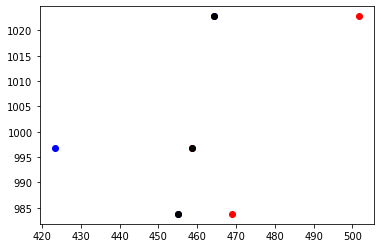

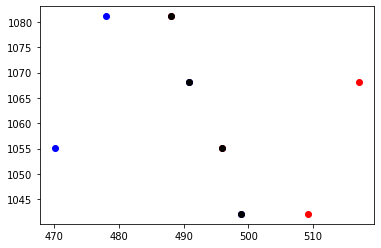

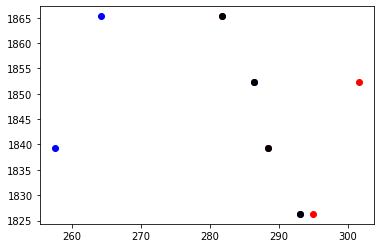

In [47]:
n = 0 # numero orbita da visualizzare
tmp = df5.loc[df5.orbit == df5.orbit.unique()[n]]#.sort_values('chamber') # a che mi serve questo sort? Tanto ad ogni x accoppio la sua z... boh

# voglio una riga per camera, ciascuna contenente tutte le hits di quella camera

# vxr = tmp.xr.to_numpy().reshape((-1, 4))
# vxl = tmp.xl.to_numpy().reshape((-1, 4))
# vxb = tmp.xb.to_numpy().reshape((-1, 4))
# vz = tmp.z.to_numpy().reshape((-1, 4))
# for i in range(3) :
#     fig, ax = plt.subplots()
#     ax.scatter(vxl[i], vz[i], c = 'blue')
#     ax.scatter(vxr[i], vz[i], c = 'red')
#     ax.scatter(vxb[i], vz[i], c = 'black')

for ch in tmp.chamber.unique() :
    vxr = tmp[tmp.chamber == ch].xr
    vxl = tmp[tmp.chamber == ch].xl
    vxb = tmp[tmp.chamber == ch].xb
    vz = tmp[tmp.chamber == ch].z

    fig, ax = plt.subplots()
    ax.scatter(vxl, vz, c = 'blue')
    ax.scatter(vxr, vz, c = 'red')
    ax.scatter(vxb, vz, c = 'black')


In [48]:
# si può fare una funzione "fit" che calcoli pendenza e intercetta (njit); questa stessa può essere usata sia per il calcolo del chi quadro che riciclata per il fit globale

***
### Il filtro della vicinanza orizzontale che fine ha fatto? Viene soppiantato dal filtro di non più di una cella attiva per layer? Verificare
***
Risposta: no. Al massimo può venire rimpiazzato da quello dei < 8 eventi per orbita, ora controllo

In [49]:
df2d = df5.copy() # pronti per il fit globale 2D; tolgo la camera 1 che è rilevante solo per quello 3d
df2d = df2d[df2d['chamber'] != 1]
df2d

,orbit,chamber,layer,center,dt,xr,xl,z,xb
3,1118948,2,1,24,96.133333,509.171973,498.828027,1042.1,498.828027
4,1118948,2,4,23,92.800000,487.992640,478.007360,1081.1,487.992640
5,1118948,2,3,24,243.833333,517.118233,490.881767,1068.1,490.881767
6,1118948,2,2,23,240.500000,495.938900,470.061100,1055.1,495.938900
7,1118948,3,1,14,17.000000,294.914600,293.085400,1826.3,293.085400
...,...,...,...,...,...,...,...,...,...
3204,5762142,0,2,25,272.633333,539.667673,510.332327,239.3,539.667673
3205,5762142,0,3,26,200.133333,556.767173,535.232827,252.3,535.232827
3206,5762142,2,1,22,23.000000,463.237400,460.762600,1042.1,460.762600
3207,5762142,2,3,22,43.833333,464.358233,459.641767,1068.1,459.641767


Importantissimo ri-assicurarsi che ogni coppia orbita/camera contenga almeno 3 punti per il fit (cosa non più scontata avendo rimosso la camera 1)!! Se no possono esserci orbite con un solo punto che soddisfano z == z.mean() banalmente!!

In [50]:
S = df2d.groupby('orbit').size()
Si = S[S > 2].index
df2d = df2d[df2d.orbit.isin(Si)] # l'indice di S è orbit!!
df2d # con solo il primo file per fortuna non cambia nulla (che è il motivo per cui non me ne sono accorto)

,orbit,chamber,layer,center,dt,xr,xl,z,xb
3,1118948,2,1,24,96.133333,509.171973,498.828027,1042.1,498.828027
4,1118948,2,4,23,92.800000,487.992640,478.007360,1081.1,487.992640
5,1118948,2,3,24,243.833333,517.118233,490.881767,1068.1,490.881767
6,1118948,2,2,23,240.500000,495.938900,470.061100,1055.1,495.938900
7,1118948,3,1,14,17.000000,294.914600,293.085400,1826.3,293.085400
...,...,...,...,...,...,...,...,...,...
3204,5762142,0,2,25,272.633333,539.667673,510.332327,239.3,539.667673
3205,5762142,0,3,26,200.133333,556.767173,535.232827,252.3,535.232827
3206,5762142,2,1,22,23.000000,463.237400,460.762600,1042.1,460.762600
3207,5762142,2,3,22,43.833333,464.358233,459.641767,1068.1,459.641767


In [51]:
# test
df2d.groupby(['orbit']).nunique()

,chamber,layer,center,dt,xr,xl,z,xb
orbit,,,,,,,,
1118948,2,4,4,8,8,8,8,8
1123056,2,4,4,6,6,6,6,6
1124284,2,4,4,8,8,8,8,8
1126947,2,4,4,8,8,8,8,8
1130581,2,4,4,7,7,7,7,7
...,...,...,...,...,...,...,...,...
5723739,1,3,2,3,3,3,3,3
5738703,1,3,2,3,3,3,3,3
5741793,2,4,5,8,8,8,8,8


In [52]:
# test
df2d['orbit'].unique().shape[0] # numero di orbite uniche

357

In [53]:
# test
df2d.groupby(['orbit']).nunique()['chamber'] > 1 # quali di queste 295 orbite hanno almeno 2 valori distinti di chamber?

orbit
1118948     True
1123056     True
1124284     True
1126947     True
1130581     True
           ...  
5723739    False
5738703    False
5741793     True
5744493    False
5762142     True
Name: chamber, Length: 357, dtype: bool

In [54]:
# test
print(df2d['orbit'].unique()[df2d.groupby(['orbit']).nunique()['chamber'] > 1].shape[0])
df2d['orbit'].unique()[df2d.groupby(['orbit']).nunique()['chamber'] > 1]

176


array([1118948, 1123056, 1124284, 1126947, 1130581, 1135298, 1144838,
       1151335, 1175583, 1190501, 1248672, 1273848, 1324275, 1340132,
       1359360, 1378974, 1457838, 1494528, 1510870, 1526415, 1563057,
       1580971, 1589457, 1616334, 1627535, 1647343, 1652809, 1678645,
       1689723, 1691363, 1696794, 1701734, 1776978, 1777546, 1785150,
       1800192, 1807938, 1843749, 1865842, 1875545, 1875743, 1875773,
       1906563, 1915299, 1974647, 1980146, 2000410, 2040732, 2175677,
       2194162, 2229354, 2243090, 2310920, 2336876, 2345052, 2355233,
       2399681, 2422956, 2468012, 2493277, 2503604, 2556847, 2565416,
       2578826, 2673209, 2684383, 2698072, 2730461, 2734116, 2751422,
       2781075, 2898095, 2933770, 2939904, 2972885, 2976721, 3005472,
       3049467, 3065545, 3094166, 3129186, 3144497, 3175239, 3197532,
       3213892, 3222537, 3315584, 3329716, 3340311, 3350971, 3366545,
       3371031, 3451489, 3479327, 3510223, 3526395, 3538387, 3582118,
       3661438, 3687

In [55]:
# da df2d devo togliere le orbite che non abbiano almeno 2 camere (senza contare 1 che ho tolto, ovviamente)
df2d = df2d[df2d.orbit.isin(df2d['orbit'].unique()[df2d.groupby(['orbit']).nunique()['chamber'] > 1])]
df2d

,orbit,chamber,layer,center,dt,xr,xl,z,xb
3,1118948,2,1,24,96.133333,509.171973,498.828027,1042.1,498.828027
4,1118948,2,4,23,92.800000,487.992640,478.007360,1081.1,487.992640
5,1118948,2,3,24,243.833333,517.118233,490.881767,1068.1,490.881767
6,1118948,2,2,23,240.500000,495.938900,470.061100,1055.1,495.938900
7,1118948,3,1,14,17.000000,294.914600,293.085400,1826.3,293.085400
...,...,...,...,...,...,...,...,...,...
3204,5762142,0,2,25,272.633333,539.667673,510.332327,239.3,539.667673
3205,5762142,0,3,26,200.133333,556.767173,535.232827,252.3,535.232827
3206,5762142,2,1,22,23.000000,463.237400,460.762600,1042.1,460.762600
3207,5762142,2,3,22,43.833333,464.358233,459.641767,1068.1,459.641767


In [56]:
# ALTERNATIVA SENZA ISIN (più dask-friendly): qualcosa tipo la seguente

def filtro2d(gruppo) :
    if len(gruppo['chamber'].unique()) > 1 :
        return gruppo
    else : 
        return None

df2d_altro = df2d.groupby("orbit").apply(filtro2d).reset_index(drop = True).dropna()
df2d_altro

,orbit,chamber,layer,center,dt,xr,xl,z,xb
0,1118948,2,1,24,96.133333,509.171973,498.828027,1042.1,498.828027
1,1118948,2,4,23,92.800000,487.992640,478.007360,1081.1,487.992640
2,1118948,2,3,24,243.833333,517.118233,490.881767,1068.1,490.881767
3,1118948,2,2,23,240.500000,495.938900,470.061100,1055.1,495.938900
4,1118948,3,1,14,17.000000,294.914600,293.085400,1826.3,293.085400
...,...,...,...,...,...,...,...,...,...
1344,5762142,0,2,25,272.633333,539.667673,510.332327,239.3,539.667673
1345,5762142,0,3,26,200.133333,556.767173,535.232827,252.3,535.232827
1346,5762142,2,1,22,23.000000,463.237400,460.762600,1042.1,460.762600
1347,5762142,2,3,22,43.833333,464.358233,459.641767,1068.1,459.641767


A giudicare dalla len df2d e df2d_altro sono uguali, buono

In [57]:
@njit
def fit(z, x) : # ricorda: nel nostro fit (rispetto a wikipedia) si ha x -> z (variabile fissa/senza errore/senza osservazioni da confrontare con predizioni) e y -> x (tutto il contrario dell'altra)
    slope = ((z - z.mean())*(x - x.mean())).sum() / ((z - z.mean())**2).sum()
    intercept = x.mean() - slope * z.mean()
    return slope, intercept # geometricamente queste due sono "sbagliate" ma filosoficamente e numericamente no!
    # questi due parametri soddisfano l'equazione x = slope*z+intercept visto quanto detto sopra su x, y e z

In [58]:
df2d[df2d.orbit == df2d.orbit.unique()[0]] # nota che i valori di z sono già globali!!

,orbit,chamber,layer,center,dt,xr,xl,z,xb
3,1118948,2,1,24,96.133333,509.171973,498.828027,1042.1,498.828027
4,1118948,2,4,23,92.800000,487.992640,478.007360,1081.1,487.992640
5,1118948,2,3,24,243.833333,517.118233,490.881767,1068.1,490.881767
6,1118948,2,2,23,240.500000,495.938900,470.061100,1055.1,495.938900
7,1118948,3,1,14,17.000000,294.914600,293.085400,1826.3,293.085400
8,1118948,3,4,13,163.033333,281.771193,264.228807,1865.3,281.771193
9,1118948,3,3,14,142.200000,301.650360,286.349640,1852.3,286.349640
10,1118948,3,2,13,288.033333,288.496193,257.503807,1839.3,288.496193


In [59]:
def plot_global_fit(event) :
    vxb = event.xb.to_numpy()
    vz = event.z.to_numpy()

    slope, intercept = fit(vz, vxb) # faccio il fit solo con le x best!
    q = -intercept/slope 
    m = 1/slope # cfr notebook di Zanetti per vedere come "raddrizzare" GEOMETRICAMENTE la retta (riflessione ortogonale)

    fig, ax = plt.subplots()
    ax.scatter(vxb, vz, c = 'black')
    ax.plot(vxb, m*vxb + q)
    ax.set_title(f'orbit {event.orbit.iloc[0]}') # nello stesso evento per definizione tutte le orbite sono uguali, basta la prima con iloc anziché unique ecc.
    ax.set_yticks(z_offset) # le altezze delle camere (le due centrali sono appiccicate)

In [60]:
print('unique number of orbits:', df2d.orbit.unique().shape[0])

unique number of orbits: 176


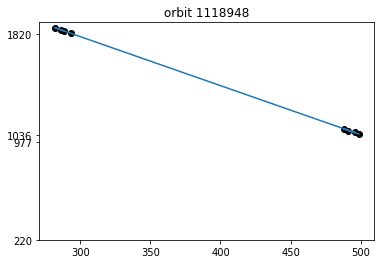

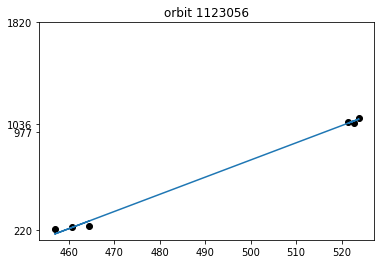

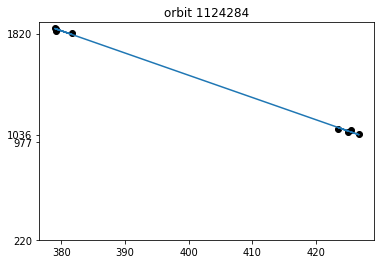

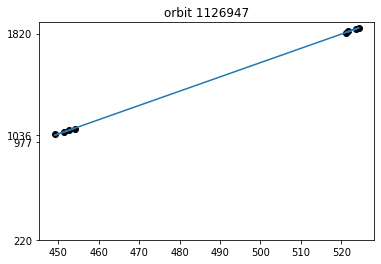

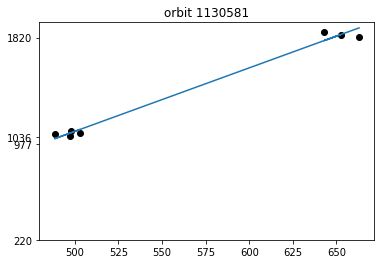

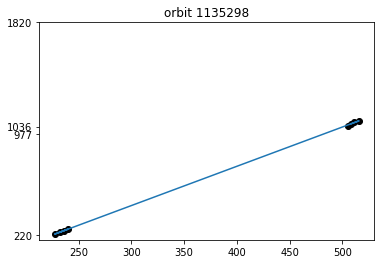

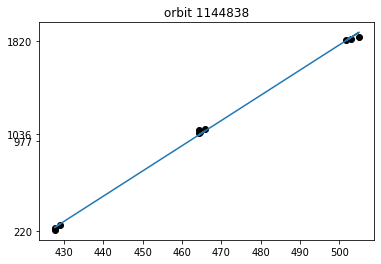

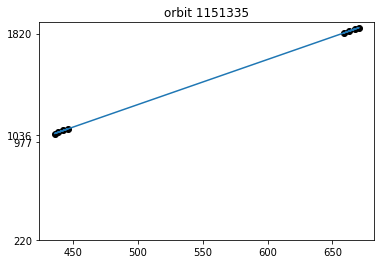

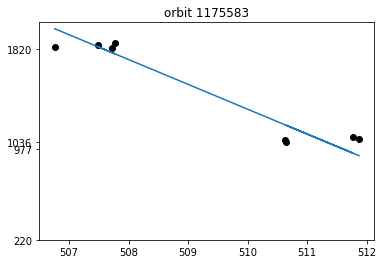

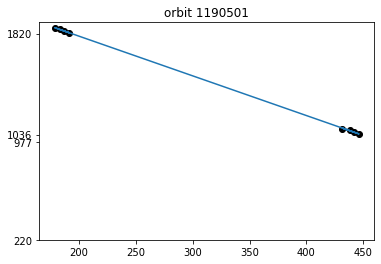

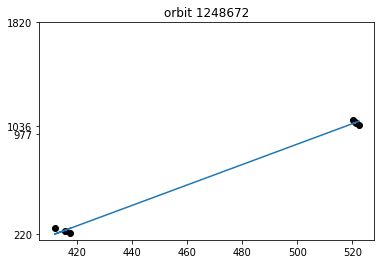

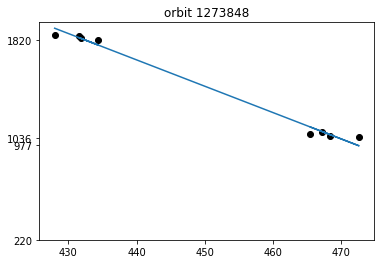

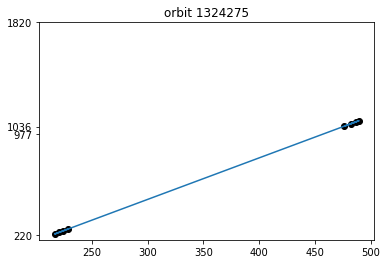

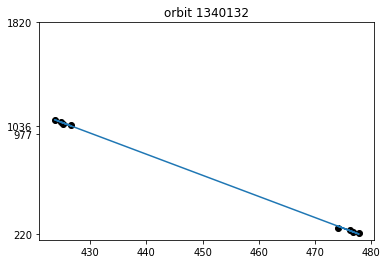

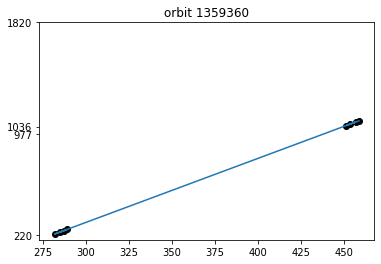

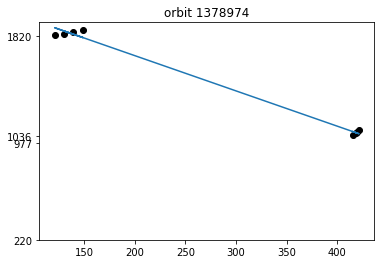

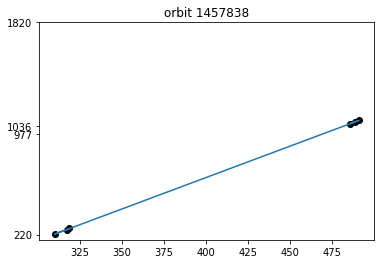

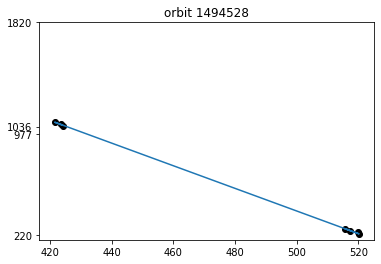

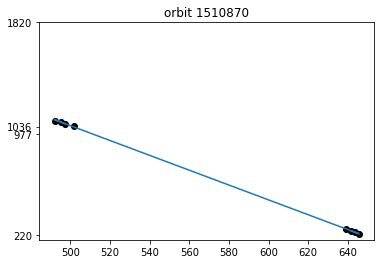

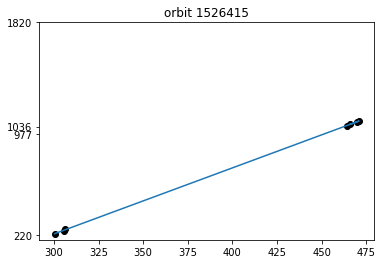

In [61]:
for i in range(20) :
    plot_global_fit(df2d[df2d.orbit == df2d.orbit.unique()[i]])

In [62]:
df2d[df2d.orbit == 1175583]

,orbit,chamber,layer,center,dt,xr,xl,z,xb
114,1175583,2,3,24,146.333333,511.872733,496.127267,1068.1,511.872733
115,1175583,2,1,24,123.633333,510.651473,497.348527,1042.1,510.651473
116,1175583,2,4,25,245.933333,538.231213,511.768787,1081.1,511.768787
117,1175583,2,2,25,267.166667,539.373567,510.626433,1055.1,510.626433
118,1175583,3,3,24,64.900000,507.491620,500.508380,1852.3,507.491620
119,1175583,3,1,24,69.066667,507.715787,500.284213,1826.3,507.715787
120,1175583,3,4,25,320.333333,542.233933,507.766067,1865.3,507.766067
121,1175583,3,2,25,339.066667,543.241787,506.758213,1839.3,506.758213


## Serve la vicinanza orizzontale
Intanto però vediamo se i residui possano essere usati in tal senso

In [63]:
def residui(gruppo) :
    # nota importante: come detto dal tipo della tesi è interessante calcolare i residui definiti rispetto al fit *globale*
    slope, intercept = fit(gruppo['z'].to_numpy(), gruppo['xb'].to_numpy()) # infatti qui fitto sui dati già senza ambiguità...
    gruppo['residui'] = gruppo['xb'] - slope*gruppo['z']-intercept # x osservato - x predetto
    return gruppo 

df2d_2 = df2d.groupby('orbit').apply(residui).reset_index(drop = True) # ...e qui NON raggruppo per chamber
df2d_2

,orbit,chamber,layer,center,dt,xr,xl,z,xb,residui
0,1118948,2,1,24,96.133333,509.171973,498.828027,1042.1,498.828027,0.284015
1,1118948,2,4,23,92.800000,487.992640,478.007360,1081.1,487.992640,-0.306193
2,1118948,2,3,24,243.833333,517.118233,490.881767,1068.1,490.881767,-0.832126
3,1118948,2,2,23,240.500000,495.938900,470.061100,1055.1,495.938900,0.809948
4,1118948,3,1,14,17.000000,294.914600,293.085400,1826.3,293.085400,0.548293
...,...,...,...,...,...,...,...,...,...,...
1344,5762142,0,2,25,272.633333,539.667673,510.332327,239.3,539.667673,1.565626
1345,5762142,0,3,26,200.133333,556.767173,535.232827,252.3,535.232827,-1.638903
1346,5762142,2,1,22,23.000000,463.237400,460.762600,1042.1,460.762600,-1.362623
1347,5762142,2,3,22,43.833333,464.358233,459.641767,1068.1,459.641767,-0.022822


4.149407691668938e-13


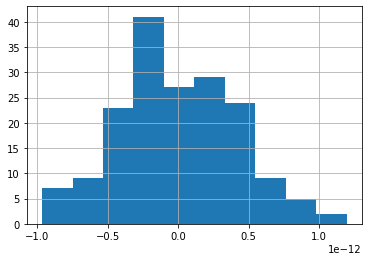

In [64]:
s = df2d_2.groupby('orbit').apply(lambda gruppo: gruppo.residui.sum())
print(s.std())
s.hist();
# assolutamente inutile (sono tutti 0 stando ai float ecc.), il che conferma che effettivamente quella di somma dei residui = 0 è una identità soddisfatta sempre per via di come calcolo alpha e beta, non eliminata da rumore o eventuali errori casuali/sistematici

In [65]:
s1 = df2d_2.groupby('chamber').apply(lambda gruppo: gruppo.residui)
s1#.hist();

chamber      
0        8       2.826694
         9      -2.832512
         10      0.059791
         37      0.170445
         38     -0.466203
                   ...   
3        1307   -3.712417
         1308   -6.112572
         1316    0.970759
         1317    0.180755
         1318    0.332385
Name: residui, Length: 1349, dtype: float64

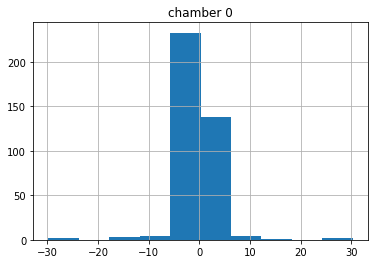

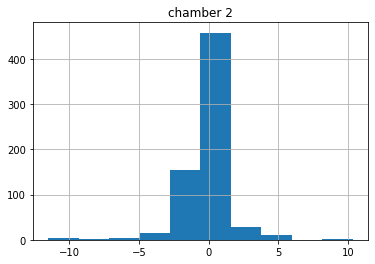

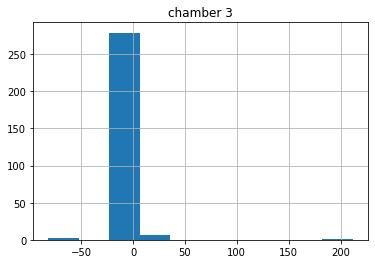

In [66]:
for i in [0, 2, 3] :
    plt.figure();
    s1[i].hist();
    plt.title(f'chamber {i}')

Chamber 2 nell'istogramma precedente: praticamente come al caruso. Camere 0 e 3: sballate dal non aver tolto quelli che non rispettano la vicinanza orizzontale!          
In ogni caso questo modo di procedere è effettivamente migliore del precedente, visto che sommando i residui relativi solo ad una camera (quindi non tutti) non ottengo necessariamente 0, anzi in generale tutt'altro!

P.S. ovviamente la camera 1 è stata esclusa da questo discorso

In [67]:
for i in [0, 2, 3] : # non c'è 1
    print('std ch.', i, '->', s1[i].std()) # e infatti le camere sballate hanno sigma enormi

std ch. 0 -> 3.766582876103844
std ch. 2 -> 1.5824606664149443
std ch. 3 -> 14.77250591878511


In [68]:
# e se provassi ad eliminare la spazzatura ricorrendo ai residui stessi?
df2d_3 = df2d_2[df2d_2.residui.abs() < 15] # valore indicativo, un po' inventato in realtà. Sarebbe meglio stimarlo sulla base dell'errore accettabile!
df2d_3

,orbit,chamber,layer,center,dt,xr,xl,z,xb,residui
0,1118948,2,1,24,96.133333,509.171973,498.828027,1042.1,498.828027,0.284015
1,1118948,2,4,23,92.800000,487.992640,478.007360,1081.1,487.992640,-0.306193
2,1118948,2,3,24,243.833333,517.118233,490.881767,1068.1,490.881767,-0.832126
3,1118948,2,2,23,240.500000,495.938900,470.061100,1055.1,495.938900,0.809948
4,1118948,3,1,14,17.000000,294.914600,293.085400,1826.3,293.085400,0.548293
...,...,...,...,...,...,...,...,...,...,...
1344,5762142,0,2,25,272.633333,539.667673,510.332327,239.3,539.667673,1.565626
1345,5762142,0,3,26,200.133333,556.767173,535.232827,252.3,535.232827,-1.638903
1346,5762142,2,1,22,23.000000,463.237400,460.762600,1042.1,460.762600,-1.362623
1347,5762142,2,3,22,43.833333,464.358233,459.641767,1068.1,459.641767,-0.022822


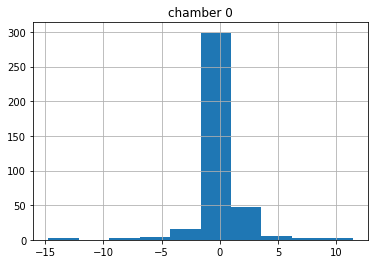

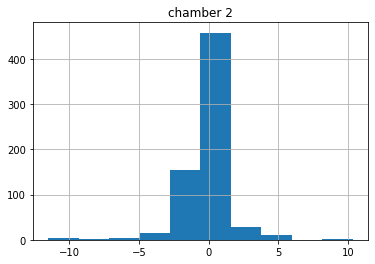

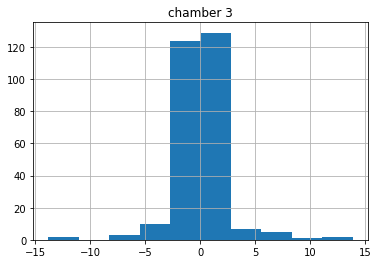

In [69]:
s2 = df2d_3.groupby('chamber').apply(lambda gruppo: gruppo.residui)

for i in [0, 2, 3] : # le uniche camere che ho a disposizione se manca la 1
    plt.figure();
    s2[i].hist();
    plt.title(f'chamber {i}');

In [70]:
for i in [0, 2, 3] : # non c'è 1
    print('std ch.', i, '->', s2[i].std())

std ch. 0 -> 2.0474717032507215
std ch. 2 -> 1.5824606664149443
std ch. 3 -> 2.340729194803116


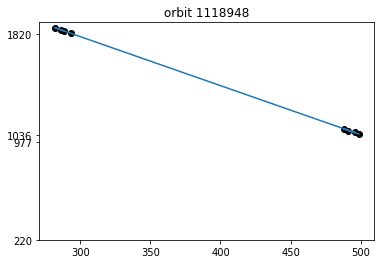

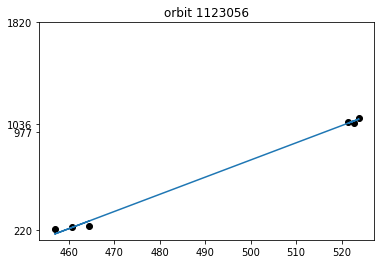

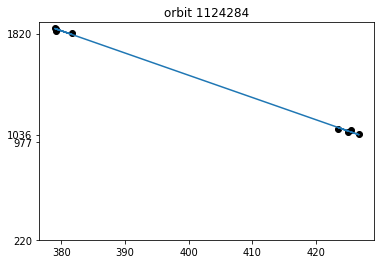

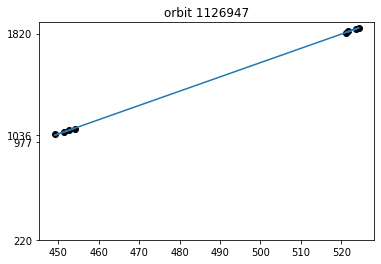

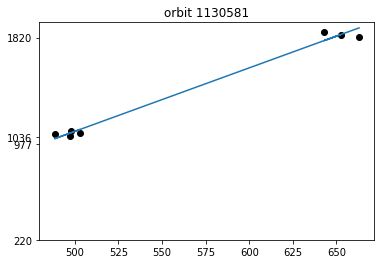

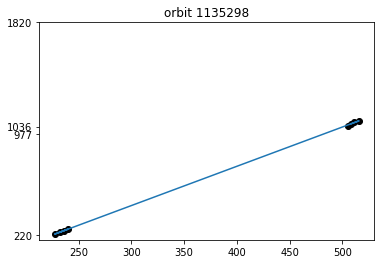

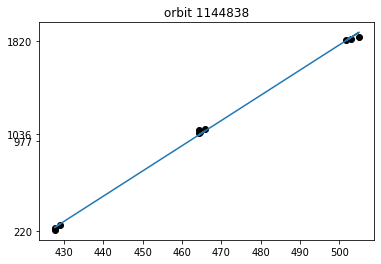

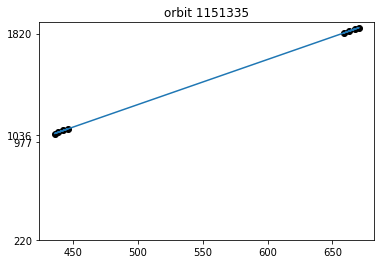

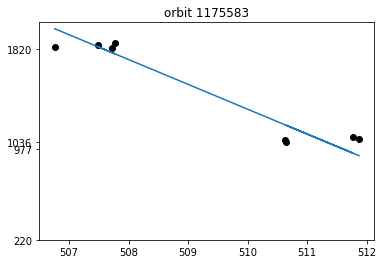

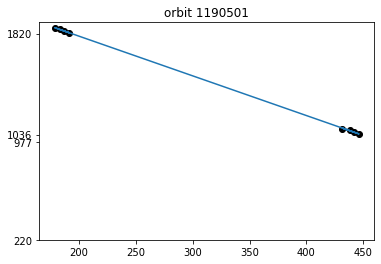

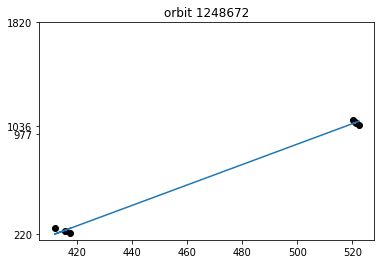

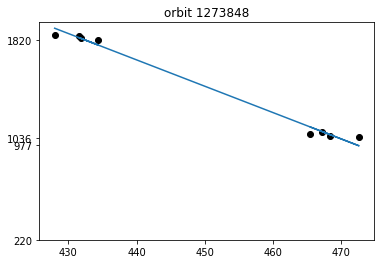

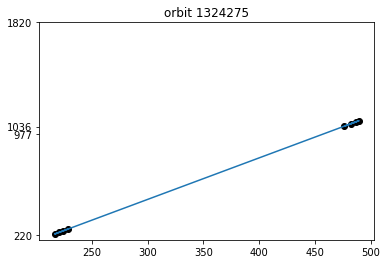

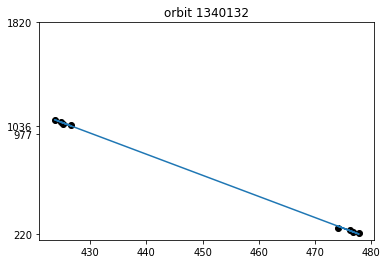

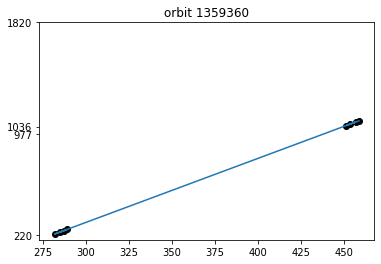

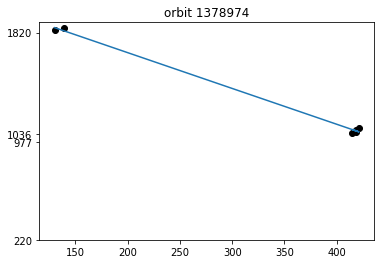

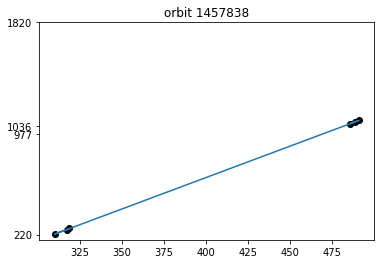

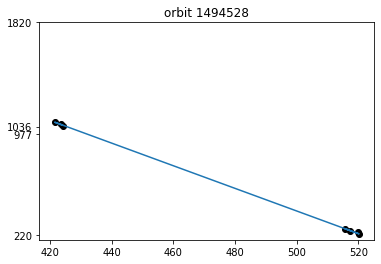

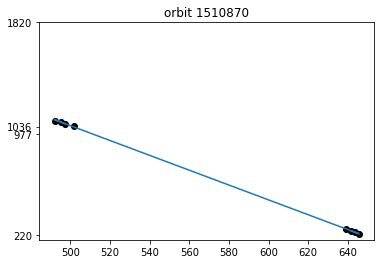

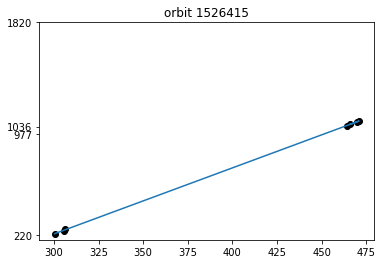

In [71]:
for i in range(20) :
    plot_global_fit(df2d_3[df2d_3.orbit == df2d_3.orbit.unique()[i]])

l'orbita 1273848 comunque si comporta male, mm... Un sigma più stringente?

In [72]:
df2d_4 = df2d_2[df2d_2.residui.abs() < 10] # valore indicativo, un po' inventato in realtà. Sarebbe meglio stimarlo sulla base dell'errore accettabile!
df2d_4

,orbit,chamber,layer,center,dt,xr,xl,z,xb,residui
0,1118948,2,1,24,96.133333,509.171973,498.828027,1042.1,498.828027,0.284015
1,1118948,2,4,23,92.800000,487.992640,478.007360,1081.1,487.992640,-0.306193
2,1118948,2,3,24,243.833333,517.118233,490.881767,1068.1,490.881767,-0.832126
3,1118948,2,2,23,240.500000,495.938900,470.061100,1055.1,495.938900,0.809948
4,1118948,3,1,14,17.000000,294.914600,293.085400,1826.3,293.085400,0.548293
...,...,...,...,...,...,...,...,...,...,...
1344,5762142,0,2,25,272.633333,539.667673,510.332327,239.3,539.667673,1.565626
1345,5762142,0,3,26,200.133333,556.767173,535.232827,252.3,535.232827,-1.638903
1346,5762142,2,1,22,23.000000,463.237400,460.762600,1042.1,460.762600,-1.362623
1347,5762142,2,3,22,43.833333,464.358233,459.641767,1068.1,459.641767,-0.022822


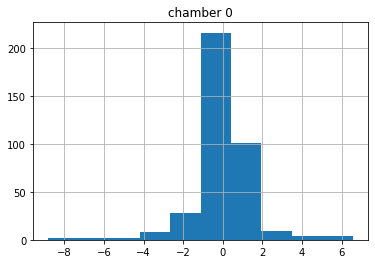

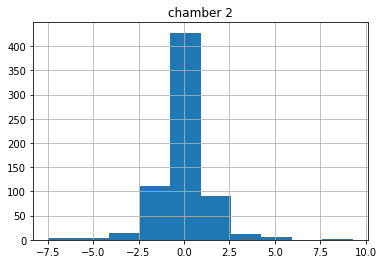

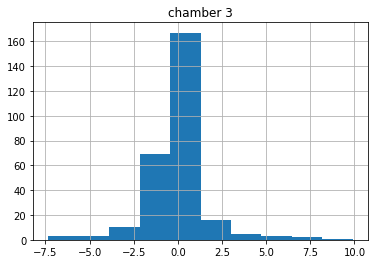

In [73]:
s3 = df2d_4.groupby('chamber').apply(lambda gruppo: gruppo.residui)

for i in [0, 2, 3] : # le uniche camere che ho a disposizione se manca la 1
    plt.figure();
    s3[i].hist();
    plt.title(f'chamber {i}');

In [74]:
for i in [0, 2, 3] : # non c'è 1
    print('std ch.', i, '->', s3[i].std())

std ch. 0 -> 1.4807716739580143
std ch. 2 -> 1.3519757123510108
std ch. 3 -> 1.7719109832281454


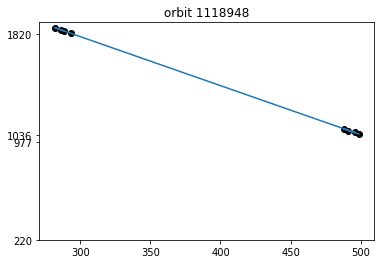

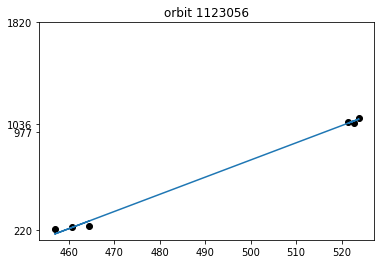

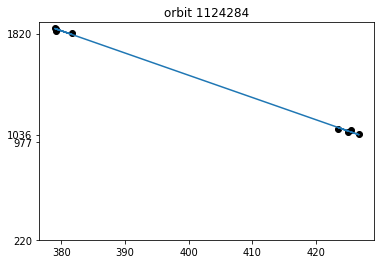

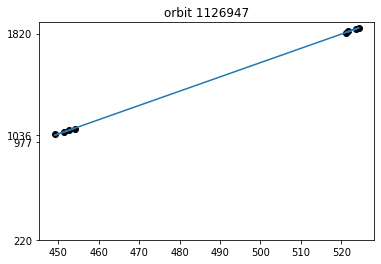

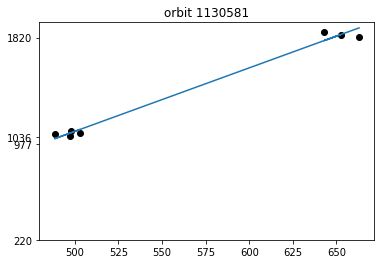

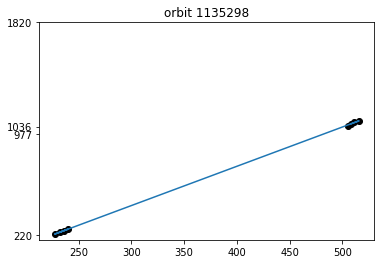

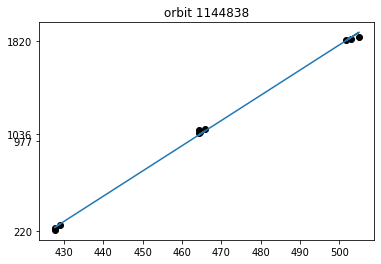

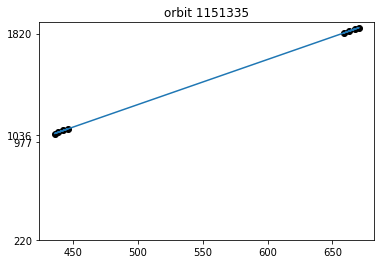

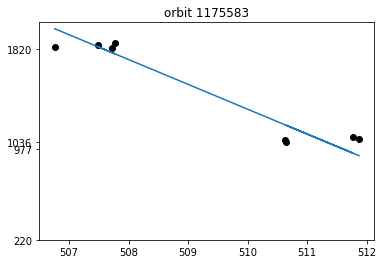

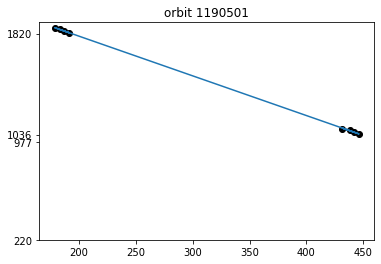

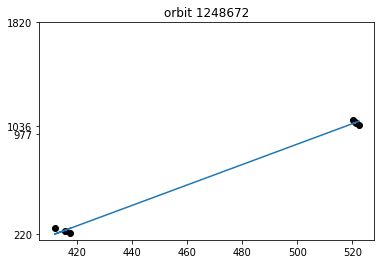

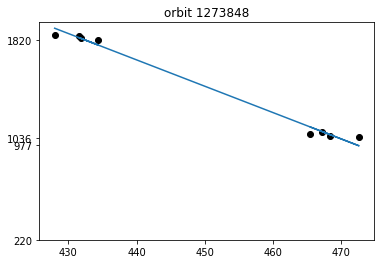

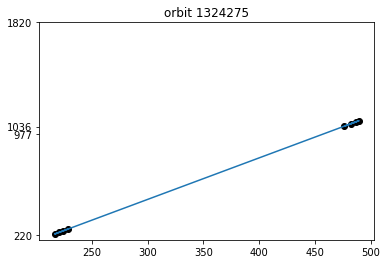

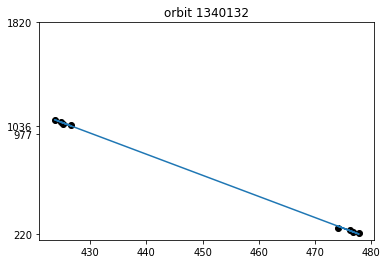

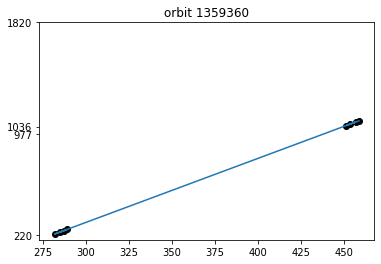

In [75]:
for i in range(15) :
    plot_global_fit(df2d_3[df2d_3.orbit == df2d_3.orbit.unique()[i]]) # ancora passa quella disgraziata, grrr

# Fit 3d: non scarto 1 e anzi chiedo che ci sia almeno un'altra camera

In [76]:
df3d = df5.copy()

def filtro3d(gruppo) :
    if 1 in gruppo.chamber.unique() and len(gruppo.chamber.unique()) > 2 : # mi serve ad esempio 0-1 per yz e 0-2 per xz, quindi camera 1 + almeno altre 2. Questo significa minimo 3 in totale!
        return gruppo 
    else :
        return None

df3d = df3d.groupby('orbit').apply(filtro3d).reset_index(drop = True).dropna()
df3d # ovviamente c'è molta più roba

,orbit,chamber,layer,center,dt,xr,xl,z,xb
0,1118948,1,1,22,127.233333,468.845153,455.154847,983.8,455.154847
1,1118948,1,2,21,328.700000,458.684060,423.315940,996.8,458.684060
2,1118948,1,4,23,347.866667,501.715227,464.284773,1022.8,464.284773
3,1118948,2,1,24,96.133333,509.171973,498.828027,1042.1,498.828027
4,1118948,2,4,23,92.800000,487.992640,478.007360,1081.1,487.992640
...,...,...,...,...,...,...,...,...,...
1510,5741793,1,1,28,223.266667,600.011747,575.988253,983.8,575.988253
1511,5741793,2,4,25,21.333333,526.147733,523.852267,1081.1,523.852267
1512,5741793,2,1,24,139.866667,511.524827,496.475173,1042.1,511.524827
1513,5741793,2,2,25,191.733333,535.315253,514.684747,1055.1,514.684747


In [77]:
#cella copiata da sopra; la rimetto qui per avere un blueprint per quella 3d e per poter fare eventuali modifiche alla stessa senza dover risalire 100 volte
def plot_global_fit(event, equal = False) :
    vxb = event.xb.to_numpy()
    vz = event.z.to_numpy()

    slope, intercept = fit(vz, vxb) # faccio il fit solo con le x best!
    q = -intercept/slope 
    m = 1/slope # cfr notebook di Zanetti per vedere come "raddrizzare" GEOMETRICAMENTE la retta (riflessione ortogonale)

    fig, ax = plt.subplots()
    ax.scatter(vxb, vz, c = 'black')
    ax.plot(vxb, m*vxb + q)
    ax.set_title(f'orbit {event.orbit.iloc[0]}')
    ax.set_yticks(z_offset) # le altezze delle camere (le due centrali sono appiccicate)

    if equal :
        ax.axis('equal')

In [78]:
# temo si possa graficare solo la retta! Infatti per le hits abbiamo solo x e z o y e z, mai tutti e tre insieme

def plot_3d(event) :
    vx = event[event.chamber != 1].xb.to_numpy()
    vzx = event[event.chamber != 1].z.to_numpy()

    vy = event[event.chamber == 1].xb.to_numpy()
    vzy = event[event.chamber == 1].z.to_numpy()

    # formule per mettere insieme le due pendenze sui due piani... (magari di intercept fai la media? O magari stampa solamente di quanto differiscono i due)
    m1, q1 = fit(vzx, vx)
    m2, q2 = fit(vzy, vy)

    #return m1, m2, -q1/m1, -q2/m2
    t = np.linspace(170, 2000) # z è sempre più o meno fra 200 e 1840, ma allungo un po'
    #t = np.linspace(-2000, 100)
    X = q1 + m1*t
    Y = q2 + m2*t
    Z = t 
    fig = px.line_3d(x = X, y = Y, z = Z) # creo la figura di go con una sola chiamata semplice mediante px, e poi aggiorno l'oggetto fig

    # BLOCCO SE VOGLIO SOLO LA FETTA DI SOTTO DI OGNI CAMERA
    # X_s, Y_s = np.meshgrid(np.linspace(0, 21+16*42, 10), np.linspace(0, 16*42, 10)) # X va da 0 a 21 + 42*16 (16 celle nei layer traslati), Y riguarda solo la camera 1 (quindi penso vada bene 16*42)
    # for i in range(4) : # le 4 camere
    #     fig.add_surface(x = X_s, y = Y_s, z = z_offset[i]*np.ones(X_s.shape))
    # alla fine penso che comunque vada bene anche una cosa meno raffinata come assumere semplicemente detector quadrati lunghi 42*16.5 mm per lato, con 13*4 mm di altezza

    l = 42*16.5
    X_s = [0, l, l, 0]*2
    Y_s = [0, 0, l, l]*2 # pure il tipo della tesi fa 4 quadrati identici, ergo non fa niente non sapere esplicitamente una dimensione né che ch1 sia ruotata
    Z_s = np.array([0]*4 + [13*4]*4)
    for i in range(4) : # le 4 camere
        fig.add_mesh3d( 
            x = X_s, y = Y_s, z = Z_s + z_offset[i],
            i = [7, 0, 0, 0, 4, 4, 6, 6, 4, 0, 3, 2], # https://stackoverflow.com/questions/60371624/drawing-a-3d-box-in-a-3d-scatterplot-using-plotly
            j = [3, 4, 1, 2, 5, 6, 5, 2, 0, 1, 6, 3],
            k = [0, 7, 2, 3, 6, 7, 1, 1, 5, 5, 7, 6],
            opacity = 0.25,
            color = '#DC143C',
            flatshading = True # fondamentale
        )

    return fig

In [79]:
p = plot_3d(df3d.loc[df3d.orbit == df3d.orbit.unique()[0]])
p

In [80]:
#p.add_mesh3d?

In [81]:
#p.add_surface?

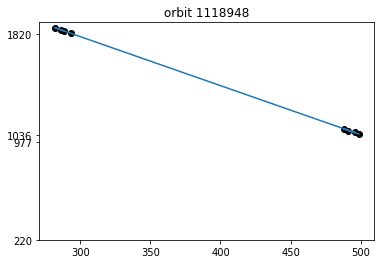

In [82]:
plot_global_fit(df3d.loc[(df3d.orbit == df3d.orbit.unique()[0]) & (df3d.chamber != 1)])

In [83]:
def plot_fit_ch1(event) :
    vyb = event.xb.to_numpy()
    vz = event.z.to_numpy()

    slope, intercept = fit(vz, vyb) # faccio il fit solo con le x best!
    q = -intercept/slope 
    m = 1/slope # cfr notebook di Zanetti per vedere come "raddrizzare" GEOMETRICAMENTE la retta (riflessione ortogonale)

    fig, ax = plt.subplots()
    ax.scatter(vyb, vz, c = 'black')
    ax.plot(vyb, m*vyb + q)
    ax.set_title(f'orbit {event.orbit.iloc[0]}')
    #ax.set_yticks(z_offset) # le altezze delle camere (le due centrali sono appiccicate)

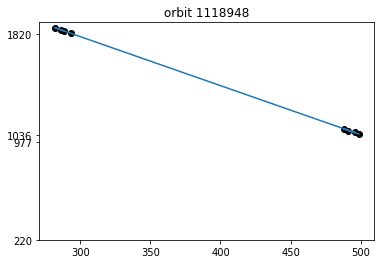

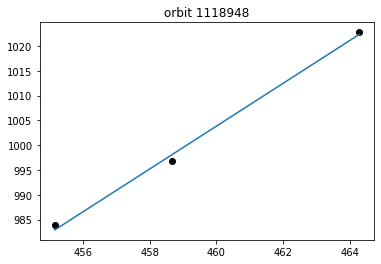

In [84]:
tmp = df3d.loc[df3d.orbit == df3d.orbit.unique()[0]]
tmp1 = tmp[tmp.chamber == 1]
tmp2 = tmp[tmp.chamber != 1]

plot_global_fit(tmp2)
plot_fit_ch1(tmp1)

In [85]:
tmp1

,orbit,chamber,layer,center,dt,xr,xl,z,xb
0,1118948,1,1,22,127.233333,468.845153,455.154847,983.8,455.154847
1,1118948,1,2,21,328.700000,458.684060,423.315940,996.8,458.684060
2,1118948,1,4,23,347.866667,501.715227,464.284773,1022.8,464.284773


In [86]:
tmp2

,orbit,chamber,layer,center,dt,xr,xl,z,xb
3,1118948,2,1,24,96.133333,509.171973,498.828027,1042.1,498.828027
4,1118948,2,4,23,92.800000,487.992640,478.007360,1081.1,487.992640
5,1118948,2,3,24,243.833333,517.118233,490.881767,1068.1,490.881767
6,1118948,2,2,23,240.500000,495.938900,470.061100,1055.1,495.938900
7,1118948,3,1,14,17.000000,294.914600,293.085400,1826.3,293.085400
8,1118948,3,4,13,163.033333,281.771193,264.228807,1865.3,281.771193
9,1118948,3,3,14,142.200000,301.650360,286.349640,1852.3,286.349640
10,1118948,3,2,13,288.033333,288.496193,257.503807,1839.3,288.496193


***
## Distanza orizzontale vs 7 eventi/orbita max
***

In [87]:
# df6 = df5.copy()
# df6 = df6[df6.chamber != 1] # se non togli la chamber 1 ti sballa i residui!! Inoltre non serve, siamo tornati ad un fit 2d
# df6 = df6.groupby('orbit').apply(residui).reset_index(drop = True) # residui rispetto al fit globale

# a sto punto tanto vale fare così
df6 = df2d_2.copy()
df6

,orbit,chamber,layer,center,dt,xr,xl,z,xb,residui
0,1118948,2,1,24,96.133333,509.171973,498.828027,1042.1,498.828027,0.284015
1,1118948,2,4,23,92.800000,487.992640,478.007360,1081.1,487.992640,-0.306193
2,1118948,2,3,24,243.833333,517.118233,490.881767,1068.1,490.881767,-0.832126
3,1118948,2,2,23,240.500000,495.938900,470.061100,1055.1,495.938900,0.809948
4,1118948,3,1,14,17.000000,294.914600,293.085400,1826.3,293.085400,0.548293
...,...,...,...,...,...,...,...,...,...,...
1344,5762142,0,2,25,272.633333,539.667673,510.332327,239.3,539.667673,1.565626
1345,5762142,0,3,26,200.133333,556.767173,535.232827,252.3,535.232827,-1.638903
1346,5762142,2,1,22,23.000000,463.237400,460.762600,1042.1,460.762600,-1.362623
1347,5762142,2,3,22,43.833333,464.358233,459.641767,1068.1,459.641767,-0.022822


std ch. 0 -> 3.766582876103844
std ch. 2 -> 1.5824606664149443
std ch. 3 -> 14.77250591878511


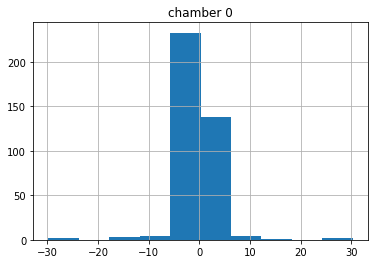

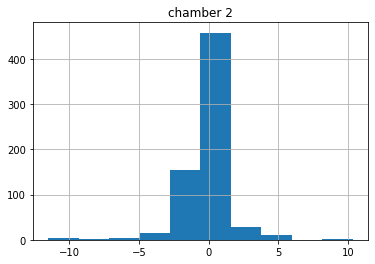

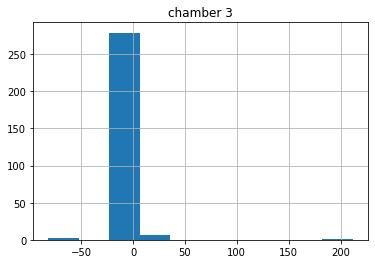

In [88]:
s4 = df6.groupby('chamber').apply(lambda gruppo: gruppo.residui)

for i in [0, 2, 3] : # ho tutte le camere a disposizione per ora
    plt.figure();
    s4[i].hist();
    plt.title(f'chamber {i}');

for i in [0, 2, 3] : # non c'è 1
    print('std ch.', i, '->', s4[i].std())

df6a = df6 + filtro orizzontale, df6b = df6 + filtro < 8 hits per evento

In [89]:
df6a = df6.copy()
df6b = df6.copy()

In [90]:
def vicinanza(gruppo) :
    #g = gruppo.sort_values('z') # layer c'è ancora
    g = gruppo.sort_values('layer')
    if (g['layer'].diff().abs() > 1).any() :
        return False # non voglio salti verticali per non dovermi preoccupare di sistemare la formula seguente
    #return (g['center'].diff().abs() < 2).all() # se le differenze orizzontali da un livello all'altro sono al più 1 ok, se superano 1 butto
    return not (g['center'].diff().abs() > 1).any() # dovrebbe essere equivalente ma più performante
    # OCCHIO A ANY VS ALL! o restituisco True quando tutte soddisfano ... < 2 (i.e. nessuna supera 1) oppure quando lo statement "almeno una supera 1" è falso e quindi il suo opposto è vero

## Come in tutti i filtri che rimuovono pezzi di orbite che però rimangono LE CONDIZIONI GLOBALI POSSONO VENIRE MENO!
Pertanto devo imporre di nuovo che ogni orbita abbia almeno 2 detector

In [91]:
# qui sto controllando una condizione locale, quindi devo necessariamente raggruppare per orbit e per chamber
df6a = df6a.groupby(['orbit', 'chamber']).filter(vicinanza)
df6a = df6a.groupby('orbit').apply(residui) # nota che siccome potenzialmente rimuovo alcune camere dentro orbite che però lascio il fit globale va aggiornato, quindi devo ricalcolare i residui

df6a = df6a.groupby('orbit').apply(filtro2d).reset_index(drop = True) # chiaramente nella versione finale applicheremo il filtro della vicinanza molto prima, ergo non ci sarà bisogno di richiedere questa condizione (che verrà verificata insieme al filtro ch2 subito dopo avere escluso chamber == 1 per fare il fit 2d)
print(len(df6a)/len(df6)*100)
df6a

71.5344699777613


,orbit,chamber,layer,center,dt,xr,xl,z,xb,residui
0,1118948,2,1,24,96.133333,509.171973,498.828027,1042.1,498.828027,0.284015
1,1118948,2,4,23,92.800000,487.992640,478.007360,1081.1,487.992640,-0.306193
2,1118948,2,3,24,243.833333,517.118233,490.881767,1068.1,490.881767,-0.832126
3,1118948,2,2,23,240.500000,495.938900,470.061100,1055.1,495.938900,0.809948
4,1118948,3,1,14,17.000000,294.914600,293.085400,1826.3,293.085400,0.548293
...,...,...,...,...,...,...,...,...,...,...
960,5741793,0,1,10,370.566667,229.936487,190.063513,226.3,229.936487,-0.634928
961,5741793,2,4,25,21.333333,526.147733,523.852267,1081.1,523.852267,-0.310192
962,5741793,2,1,24,139.866667,511.524827,496.475173,1042.1,511.524827,0.757374
963,5741793,2,2,25,191.733333,535.315253,514.684747,1055.1,514.684747,-0.547708


In [92]:
df6a.iloc[:8] # sembra ok

,orbit,chamber,layer,center,dt,xr,xl,z,xb,residui
0,1118948,2,1,24,96.133333,509.171973,498.828027,1042.1,498.828027,0.284015
1,1118948,2,4,23,92.800000,487.992640,478.007360,1081.1,487.992640,-0.306193
2,1118948,2,3,24,243.833333,517.118233,490.881767,1068.1,490.881767,-0.832126
3,1118948,2,2,23,240.500000,495.938900,470.061100,1055.1,495.938900,0.809948
4,1118948,3,1,14,17.000000,294.914600,293.085400,1826.3,293.085400,0.548293
5,1118948,3,4,13,163.033333,281.771193,264.228807,1865.3,281.771193,-0.520735
6,1118948,3,3,14,142.200000,301.650360,286.349640,1852.3,286.349640,0.642652
7,1118948,3,2,13,288.033333,288.496193,257.503807,1839.3,288.496193,-0.625854


In [93]:
# TEST
# tmp = df6a[(df6a.orbit == 1175583) & (df6a.chamber != 1)].sort_values(['chamber', 'layer'])
# tmp

In [94]:
# TEST
# plot_global_fit(tmp)

In [95]:
# TEST
# plot_global_fit(tmp, equal = True)

In [96]:
# TEST
# tmp2 = tmp.copy()
# residui(tmp2)
# tmp2

In [97]:
# TEST
# m, q = fit(tmp.z.to_numpy(), tmp.xb.to_numpy())
# print(m, q)
# print(np.vstack((tmp.xb.to_numpy(), m*tmp.z.to_numpy()+q)).T) #, tmp.residui
# print(tmp.residui.to_numpy())
# print(tmp2.residui.to_numpy())
# print(tmp.xb.to_numpy() - (m*tmp.z.to_numpy()+q))

In [98]:
# TEST
# from inspect import getsource 
# print(getsource(residui))

In [99]:
# TEST
# np.allclose(df2d_2[df2d_2.orbit == 1175583].sort_values(['chamber', 'layer']).residui.to_numpy(), tmp.xb.to_numpy() - (m*tmp.z.to_numpy()+q)) # ok, avevo sbagliato nel rifare i residui in df6 mentre invece df2d_2 era giusto

In [100]:
# TEST GRRR (prima di sistemare i delta t sballati)
# grr = df6a[df6a.residui == df6a.residui.max()].orbit.iloc[0]
# tmp = df6a[df6a.orbit == grr].sort_values(['chamber', 'layer'])
# display(tmp)
# plot_global_fit(tmp)

In [101]:
# nota che in df6 ho già risolto l'ambiguità e calcolato i residui, quindi mi interessa solo la prospettiva globale; pertanto non mi serve raggruppare per camera, solo per orbita
sb = df6b.groupby('orbit').size()
sbb = sb[sb < 8].index
# sb2 = df6.groupby('orbit').nunique()['chamber']*7
# sbb = sb[sb < sb2].index
df6b = df6b[df6b.orbit.isin(sbb)]
print(len(df6b)/len(df6)*100)
df6b
# non ho bisogno di ricalcolare i residui perché o tengo o butto tutta l'orbita, che è la sola cosa a decidere le sorti del fit globale

40.252038547071905


,orbit,chamber,layer,center,dt,xr,xl,z,xb,residui
8,1123056,0,3,22,45.966667,464.473007,459.526993,252.3,464.473007,2.826694
9,1123056,0,1,22,95.766667,467.152247,456.847753,226.3,456.847753,-2.832512
10,1123056,0,2,21,366.600000,460.723080,421.276920,239.3,460.723080,0.059791
11,1123056,2,4,25,21.533333,526.158493,523.841507,1081.1,523.841507,-0.476328
12,1123056,2,2,25,65.900000,528.545420,521.454580,1055.1,521.454580,-0.897208
...,...,...,...,...,...,...,...,...,...,...
1344,5762142,0,2,25,272.633333,539.667673,510.332327,239.3,539.667673,1.565626
1345,5762142,0,3,26,200.133333,556.767173,535.232827,252.3,535.232827,-1.638903
1346,5762142,2,1,22,23.000000,463.237400,460.762600,1042.1,460.762600,-1.362623
1347,5762142,2,3,22,43.833333,464.358233,459.641767,1068.1,459.641767,-0.022822


In [102]:
len(df6b.groupby('orbit').size())

79

In [103]:
sb.reset_index().sort_values('orbit').set_index('orbit')

,0
orbit,
1118948,8
1123056,6
1124284,8
1126947,8
1130581,7
...,...
5634684,10
5675498,8
5722385,8


In [104]:
df6.groupby('orbit').nunique()['chamber']

orbit
1118948    2
1123056    2
1124284    2
1126947    2
1130581    2
          ..
5634684    3
5675498    2
5722385    2
5741793    2
5762142    2
Name: chamber, Length: 176, dtype: int64

In [105]:
# test per qui sopra
df6.groupby('orbit').nunique()['chamber']

orbit
1118948    2
1123056    2
1124284    2
1126947    2
1130581    2
          ..
5634684    3
5675498    2
5722385    2
5741793    2
5762142    2
Name: chamber, Length: 176, dtype: int64

std ch. 0 -> 3.1240873291847784
std ch. 2 -> 1.5718392167577346
std ch. 3 -> 2.5511823378167824


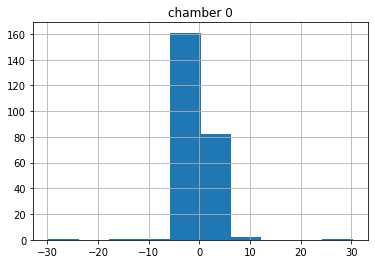

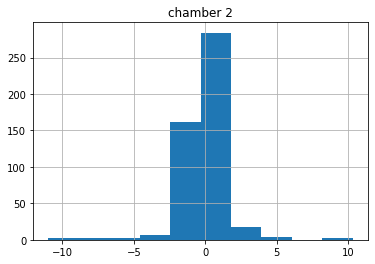

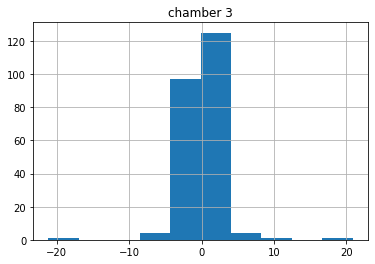

In [106]:
s5a = df6a.groupby('chamber').apply(lambda gruppo: gruppo.residui)

for i in [0, 2, 3] : # ho tutte le camere tranne la 1
    plt.figure();
    s5a[i].hist();
    plt.title(f'chamber {i}');

for i in [0, 2, 3] : # non c'è 1
    print('std ch.', i, '->', s5a[i].std())

In [107]:
# for reference
for i in [0, 2, 3] : # non c'è 1
    print('std ch.', i, '->', s4[i].std())

std ch. 0 -> 3.766582876103844
std ch. 2 -> 1.5824606664149443
std ch. 3 -> 14.77250591878511


std ch. 0 -> 4.6521318986682925
std ch. 2 -> 1.4126206751929418
std ch. 3 -> 26.353532287143146


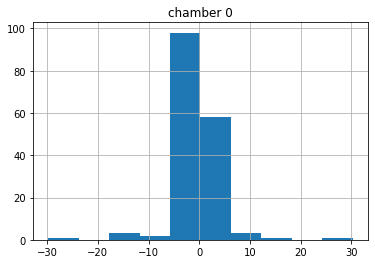

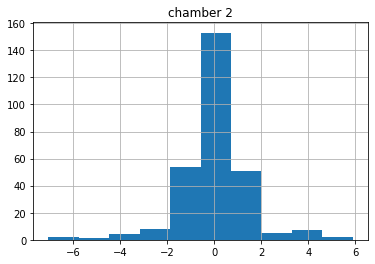

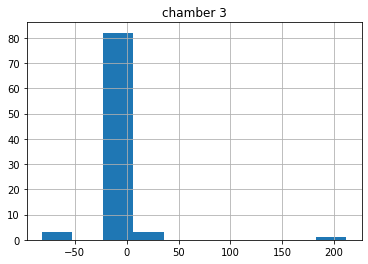

In [108]:
s5b = df6b.groupby('chamber').apply(lambda gruppo: gruppo.residui)

for i in [0, 2, 3] : # ho tutte le camere a disposizione per ora
    plt.figure();
    s5b[i].hist();
    plt.title(f'chamber {i}');

for i in [0, 2, 3] : # non c'è 1
    print('std ch.', i, '->', s5b[i].std())

In [109]:
# curiosità
# (dagli tempo che ci vuole un po' perché si disimpalli)
for i in range(10) :
    plot_3d(df3d.loc[df3d.orbit == df3d.orbit.unique()[i]]).show() # senza .show() non si vede niente >:( (idem usando una list comprehension o cose così)
# simpatico il penultimo che si vede (ruotalo un po' per capire cosa stia succedendo)

# Risoluzione & range del detector
Nota: se anche faccio la distribuzione degli angoli questo non mi dice molto riguardo i possibili valori misurabili dal detector quanto piuttosto riguardo agli eventi che hanno superato i filtri (quindi non penso che l'interpretazione del tipo sia opportuna/corretta/?).          
Meglio calcolare la risoluzione come dice Pazzini (globale vs camera 2), e in caso in qualche altro modo ancora

Altra nota: il caruso aveva pure la ch 3 ruotata (vedi ad es. la foto a p. 24), quindi lui poteva stimare la risoluzione anche su yz (cosa a noi impossibile)

## Metodo Pazzini
i.e. fit globale vs fit locale nella chamber 2

In [110]:
#df7 = df6.copy() # è df2d_2, di fatto, ma queste copie sono gratis ihih

df7 = df6a.copy() # adesso che ho sistemato il filtro della vicinanza uso direttamente questo

# nota: df2d e derivate hanno già almeno 2 camere attive per orbita (senza contare la ch 1 che è stata tolta), quindi mi basta verificare che ci sia la 2
orbite_con_2 = df7[df7.chamber == 2].orbit
df7 = df7[df7.orbit.isin(orbite_con_2)]
df7

,orbit,chamber,layer,center,dt,xr,xl,z,xb,residui
0,1118948,2,1,24,96.133333,509.171973,498.828027,1042.1,498.828027,0.284015
1,1118948,2,4,23,92.800000,487.992640,478.007360,1081.1,487.992640,-0.306193
2,1118948,2,3,24,243.833333,517.118233,490.881767,1068.1,490.881767,-0.832126
3,1118948,2,2,23,240.500000,495.938900,470.061100,1055.1,495.938900,0.809948
4,1118948,3,1,14,17.000000,294.914600,293.085400,1826.3,293.085400,0.548293
...,...,...,...,...,...,...,...,...,...,...
960,5741793,0,1,10,370.566667,229.936487,190.063513,226.3,229.936487,-0.634928
961,5741793,2,4,25,21.333333,526.147733,523.852267,1081.1,523.852267,-0.310192
962,5741793,2,1,24,139.866667,511.524827,496.475173,1042.1,511.524827,0.757374
963,5741793,2,2,25,191.733333,535.315253,514.684747,1055.1,514.684747,-0.547708


In [111]:
# alternativa dask friendly:
df7_altro = df6a.copy()

def ch2(gruppo) :
    if 2 in gruppo['chamber'].to_numpy() : # senza questo to_numpy() NON funziona (mostra solo il primo), probabilmente perché guarda se 2 è presente in qualcosa d'altro rispetto ai valori (che sono gli unici che ci interessino)
        return gruppo
    else :
        return None 

df7_altro = df7_altro.groupby('orbit').apply(ch2).dropna().reset_index(drop = True)
#df7_altro
print(np.allclose(df7, df7_altro)) # ok, sono effettivamente equivalenti

True


In [112]:
print(len(df7)/len(df6a)*100) # ok, cioè 2 c'è praticamente sempre, buono a sapersi (non che mi cambi qualcosa xDD)

99.27461139896373


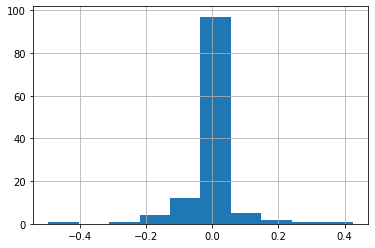

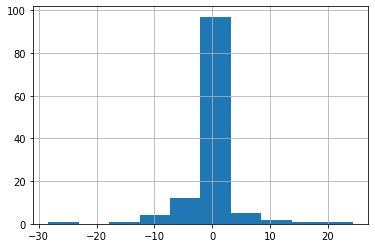

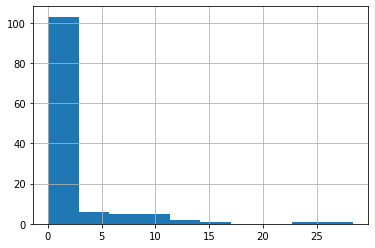

In [113]:
# def risoluzione(gruppo) :
#     M, Q = fit(gruppo.z.to_numpy(), gruppo.xb.to_numpy()) # globale
#     m, q = fit(gruppo[gruppo.chamber == 2].z.to_numpy(), gruppo[gruppo.chamber == 2].xb.to_numpy()) # locale
#     # nota che questi m sono i reciproci rispetto a quelli della geometria "corretta"
#     # ...

# preferisco avere ANCHE (possono benissimo coesistere, ma non è fondamentale questa osservazione) una funzione generica che calcoli l'alpha secondo un fit qualunque (locale o globale); prendere direttamente le differenze dentro la funzione è probabilmente più veloce che applicare due volte la stessa funzione e fare le differenze, ma siccome per avere gli istogrammi devo comunque chiamare la funzione sui due fit tanto vale salvare una tantum le due serie e farci i conti dopo

pi2 = np.pi/2

def risoluzione(gruppo) :
    ch2_x, ch2_z = gruppo[gruppo['chamber'] == 2].xb.to_numpy(), gruppo[gruppo['chamber'] == 2].z.to_numpy()
    m, q = fit(ch2_z, ch2_x) # locale
    M, Q = fit(gruppo.z.to_numpy(), gruppo.xb.to_numpy()) # globale

    angolo_locale = np.sign(m)*(pi2 - np.abs(np.arctan(1/m))) 
    angolo_globale = np.sign(M)*(pi2 - np.abs(np.arctan(1/M))) 
    return angolo_globale - angolo_locale # angolo in radianti rispetto alla verticale

# le righe seguenti si riferiscono a quando "risoluzione" calcolava angoli anziché differenze di angoli, ignorale
# # le seguenti sono tutte serie con orbit come indice, com'è giusto che sia
# globale = df7.groupby('orbit').apply(risoluzione)
# locale = df7[df7.chamber == 2].groupby('orbit').apply(risoluzione)
# r = globale - locale
# r.hist()

# ra = r.abs()
# plt.figure()
# ra.hist(); # non so bene quale tenere, boh

a = df7.groupby('orbit').apply(risoluzione)
b = a*180/np.pi
a.hist()
plt.figure()
b.hist()
plt.figure()
b.abs().hist();

In [114]:
b.abs().max() # ora che ho sistemato il calcolo di z ci siamo, tutte le discrepanze globale - locale stanno sotto i +- 30 gradi

28.345115768998852

In [115]:
# vecchia risoluzione
#r[r.abs() < 2].hist(); # mmm... Sopra ancora ci sono alcuni eventi che mi sballano tutto, credo che l'unica sia veramente scartare in base ai residui

In [116]:
print(df6.residui.max())
print(df6a.residui.max())
print(df6b.residui.max())
# eh!!

211.81790445002912
30.28230692567584
211.81790445002912


In [117]:
# vecchia risoluzione
# globale2 = df7[df7.residui < 10].groupby('orbit').apply(risoluzione)
# locale2 = df7[(df7.residui < 10) & (df7.chamber == 2)].groupby('orbit').apply(risoluzione)
# r2 = globale2 - locale2
# r2.hist();

In [118]:
# vecchia risoluzione
#(r - r2).hist(); # sì, sono praticamente uguali... mmm...

In [119]:
# vecchia risoluzione
#r.mean() # penso basti questo...? Anche se una qualche nozione di "a volte sballa" non sarebbe male

In [120]:
# vecchia risoluzione
#ra.mean() # inoltre questo probabilmente è più onesto del precedente, dove numeri di segno opposto si ammazzano facilmente facendomi perdere informazione

In [121]:
# vecchia risoluzione
#ra.mean()*180/np.pi

In [122]:
# vecchia risoluzione
#r.std()*180/np.pi # mi serve veramente?

In [123]:
# vecchia risoluzione
#globale.hist();

In [124]:
# vecchia risoluzione
#locale.hist();

Da notare che come al tipo abbiamo traiettorie sotto circa 1 radiante, però ce ne sono anche di molto più inclinate...

30.28230692567584


,orbit,chamber,layer,center,dt,xr,xl,z,xb,residui
538,3699415,0,2,5,241.200000,117.976560,92.023440,239.3,92.023440,-29.773541
537,3699415,0,3,6,40.566667,128.182487,123.817513,252.3,128.182487,0.436406
539,3699415,0,4,7,315.566667,163.977487,130.022513,265.3,163.977487,30.282307
542,3699415,2,1,24,270.300000,518.542140,489.457860,1042.1,489.457860,0.281106
541,3699415,2,2,23,221.333333,494.907733,471.092267,1055.1,494.907733,-0.218120
540,3699415,2,3,24,65.700000,507.534660,500.465340,1068.1,500.465340,-0.609613
543,3699415,2,4,25,341.533333,543.374493,506.625507,1081.1,506.625507,-0.398546


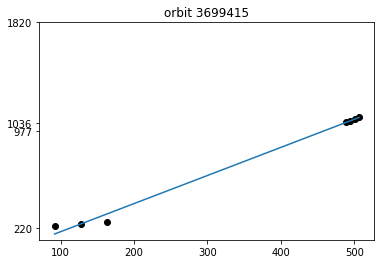

In [125]:
grr = df6a[df6a.residui == df6a.residui.max()].orbit.iloc[0] #1378974
tmp = df6a[df6a.orbit == grr].sort_values(['chamber', 'layer'])
print(tmp.residui.max())
display(tmp)
plot_global_fit(tmp)

In [126]:
a[grr]*180/np.pi

0.8919427449184653

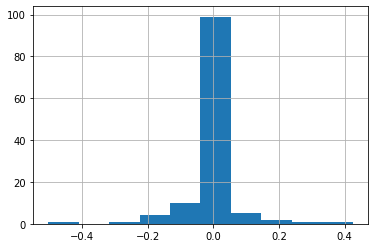

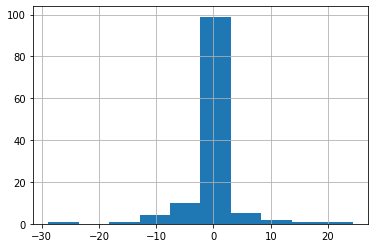

In [127]:
df6a2 = df6a[df6a.residui < 10].groupby('orbit').apply(ch2).reset_index(drop = True).groupby('orbit').apply(filtro2d).reset_index(drop = True) # tolgo singole righe --> rompo le 2 condizioni necessarie a fare il fit 2d
df6a2.groupby('orbit').apply(risoluzione).hist()
plt.figure()
(180/np.pi*(df6a2.groupby('orbit').apply(risoluzione))).hist(); # con 10 come residuo massimo non cambia niente, praticamente

In [128]:
len(df6a[df6a.residui < 10].groupby('orbit').apply(ch2).reset_index(drop = True).groupby('orbit').apply(filtro2d).reset_index(drop = True))/len(df6a)

0.9875647668393782

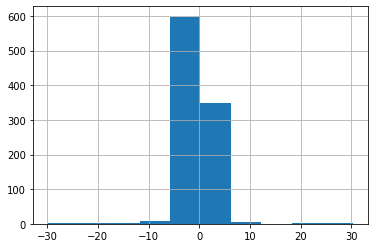

In [129]:
df6a.residui.hist();

In [130]:
len(df6a[df6a.residui < 10])/len(df6a)*100

99.48186528497409

In [131]:
ca = df6.copy()
ca = ca.set_index('orbit')
ca.index

UInt64Index([1118948, 1118948, 1118948, 1118948, 1118948, 1118948, 1118948,
             1118948, 1123056, 1123056,
             ...
             5741793, 5741793, 5741793, 5741793, 5762142, 5762142, 5762142,
             5762142, 5762142, 5762142],
            dtype='uint64', name='orbit', length=1349)

In [132]:
# vecchia risoluzione
# globale3 = df7[df7.residui < 2].groupby('orbit').apply(risoluzione)
# locale3 = df7[(df7.residui < 2) & (df7.chamber == 2)].groupby('orbit').apply(risoluzione)
# r3 = globale3 - locale3
# r3.hist();

In [133]:
# angolo = np.pi/2
# len(r[r < angolo])/len(r)*100

In [134]:
# vecchia risoluzione
# r[r.abs() < angolo].hist();

In [135]:
# vecchia risoluzione
# print('gradi:', r[r.abs() < angolo].std()*180/np.pi)
# print('radianti:', r[r.abs() < angolo].std())

In [136]:
print('gradi:', a.std()*180/np.pi)
print('radianti:', a.std())

gradi: 4.9352785550571125
radianti: 0.08613686028881486


In [137]:
# vecchia risoluzione
# r[r.abs() < 30*np.pi/180].hist();

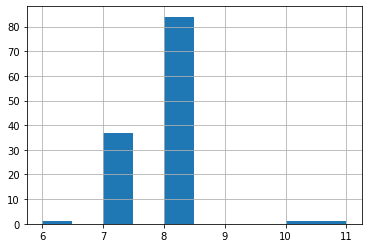

In [138]:
df7.groupby('orbit').size().hist();

In [139]:
# vecchia risoluzione
# # non differenza eccessiva fra fit locale e globale (filtro nuovo)
# ang = np.pi/2
# df8 = df7.groupby('orbit').filter(lambda gruppo: risoluzione(gruppo) < ang)
# df8.groupby('orbit').size().hist();

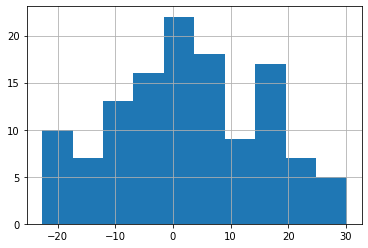

In [140]:
# angoli osservati
def angolo(gruppo) :
    m, q = fit(gruppo.z.to_numpy(), gruppo.xb.to_numpy())
    return (pi2 - np.abs(np.arctan(1/m)))*np.sign(m)

(df7.groupby('orbit').apply(angolo)*180/np.pi).hist();

In [141]:
#(df8.groupby('orbit').apply(angolo)*180/np.pi).hist();

In [142]:
# PROBLEMA DELLA RISOLUZIONE:

# magari sarebbe simpatico un approccio bayesiano? Tipo che uso il solito modello lineare/gaussiano e stimo quanto possa essere grande la variabilità degli scarti generati (sigma)
# media nota: attorno a 0, nel senso che scarti in positivo o in negativo sono equiprobabili (tipo)

### Disegno detector

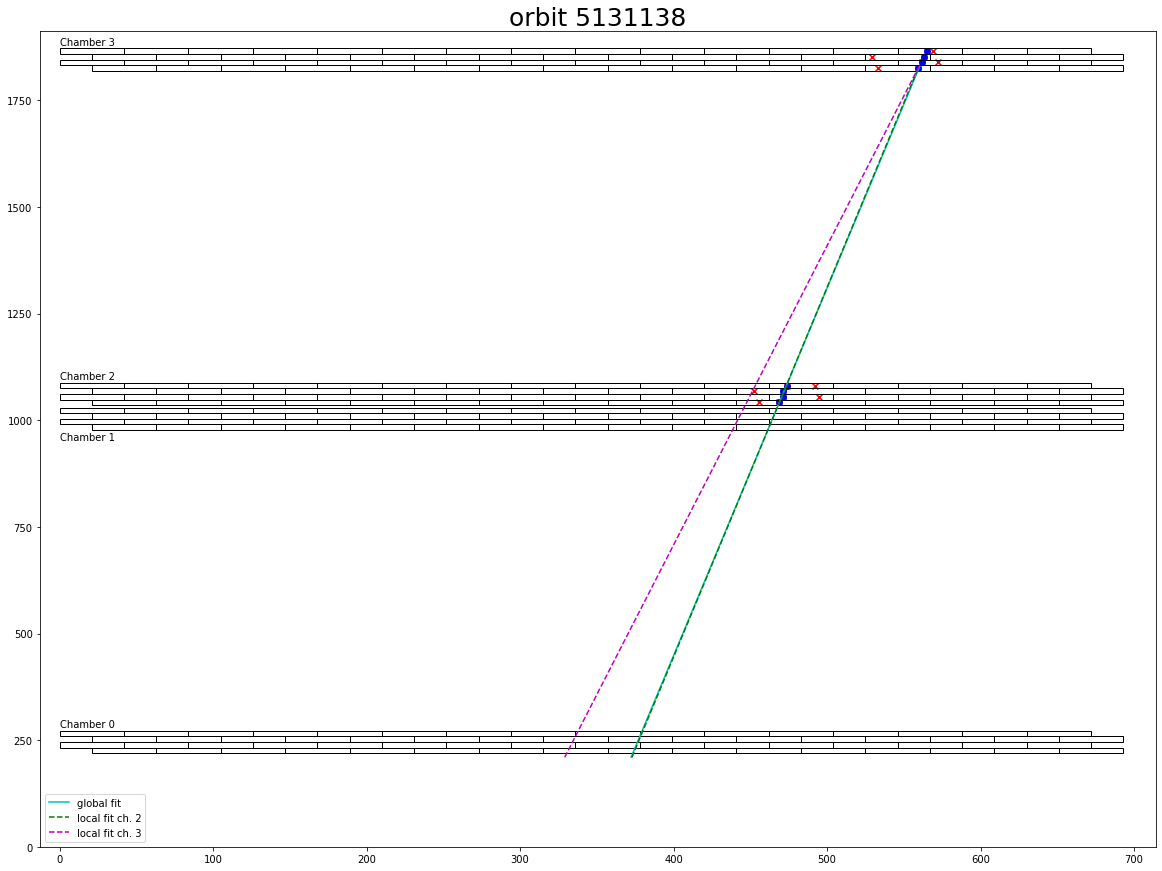

In [143]:
def plot_global_fit_chambers(event) :
    fig, ax = plt.subplots(figsize = (20, 15)) # figsize = (1.5*4.2*17, 1.5*1.3*6) figsize = (20, 60)

    # dimensions of one cell
    dx = 42
    dz = 13

    # draw the detector
    ax.set_xlim(-13, 42*16 + 42)
    #ax.set_ylim(-13, (13*4 + 13))
    ax.set_ylim(0, z_offset[-1] + 13*4 + 40)

    # coordinate del punto in basso a sinistra
    x2 = x4 = np.arange(16)*dx 
    x1 = x3 = x2 + dx/2 # queste 3 righe rappresentano i layers, non le camere
    #[z1, z2, z3, z4] = np.arange(4)*dz 

    X = np.vstack((x1, x2, x3, x4)) # ogni riga è un layer
    Z = np.array([np.arange(4)*dz +z_offset[i] for i in range(4)])
    #Z = np.array([z1, z2, z3, z4])

    for ch in range(4) : # le camere
        for i in range(4) : # i 4 layer in una camera
            for j in range(16) : # le 16 celle in un dato layer
                ax.add_patch(Rectangle((X[i][j], Z[ch][i]), dx, dz, edgecolor = 'black', facecolor = 'none')) # , linewidth = 10
                #ax.axis('off')

    ax.scatter(event.xr, event.z, marker = "x", c = "red") # , s = 500, linewidth = 7
    ax.scatter(event.xl, event.z, marker = "x", c = "red") # , s = 500, linewidth = 7
    ax.scatter(event.xb, event.z, c = "blue") #, s = 500, linewidth = 7

    # fit globale
    slope, intercept = fit(event.z.to_numpy(), event.xb.to_numpy())
    M, Q = 1/slope, -intercept/slope
    #ax.plot(event.xb, M*event.xb + Q, 'c--')

    def xplot(m, q) :
        zmin, zmax = z_offset[0] - 10, z_offset[-1] + 10
        return np.array([(zmin - q)/m, (zmax-q)/m])

    ax.plot(xplot(M, Q), M*xplot(M, Q) + Q, 'c', label = 'global fit') # invertendo z = mx+q trovo (z-q)/m = x, da cui le x corrispondenti a zmin e zmax

    # fit locale
    markers = ['b--', 'g--', 'm--']
    for ch in event.chamber.unique() :
        slope, intercept = fit(event[event.chamber == ch].z.to_numpy(), event[event.chamber == ch].xb.to_numpy())
        m, q = 1/slope, -intercept/slope
        #ax.plot(event[event.chamber == ch].xb, m*event[event.chamber == ch].xb + q, 'b--')
        ax.plot(xplot(m, q), m*xplot(m, q)+ q, markers[ch-1], label = f'local fit ch. {ch}')


    ax.set_title(f'orbit {event.orbit.iloc[0]}', fontsize = 25)
    ax.legend(loc = 'lower left', fontsize = 10)
    ax.text(x = 0, y = z_offset[3] + 60, s = "Chamber 3", fontsize = 10)
    ax.text(x = 0, y = z_offset[2] + 60, s = "Chamber 2", fontsize = 10)
    ax.text(x = 0, y = z_offset[1] -25, s = "Chamber 1", fontsize = 10)
    ax.text(x = 0, y = z_offset[0] + 60, s = "Chamber 0", fontsize = 10)
    return ax

#tmp = df7[df7.orbit == df7.orbit.unique()[2]]
tmp = df7[df7.orbit == a.index[a.abs().argmin()]]
plot_global_fit_chambers(tmp);

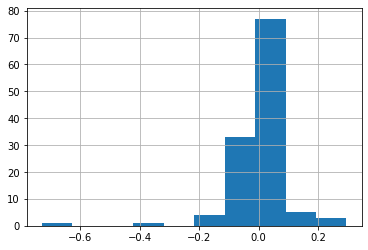

In [144]:
def risoluzione_media(gruppo) :
    M, Q = fit(gruppo.z.to_numpy(), gruppo.xb.to_numpy()) # globale
    differenze = np.zeros(len(gruppo.chamber.unique()))

    for i, ch in enumerate(gruppo.chamber.unique()) :
        ch_x, ch_z = gruppo[gruppo['chamber'] == ch].xb.to_numpy(), gruppo[gruppo['chamber'] == ch].z.to_numpy()
        m, q = fit(ch_z, ch_x) # locale
        angolo_locale = np.sign(m)*(pi2 - np.abs(np.arctan(1/m))) 
        angolo_globale = np.sign(M)*(pi2 - np.abs(np.arctan(1/M))) 
        differenze[i] = angolo_globale - angolo_locale # angolo in radianti rispetto alla verticale
    return differenze.mean()

d = df7.groupby('orbit').apply(risoluzione_media)
d.hist();

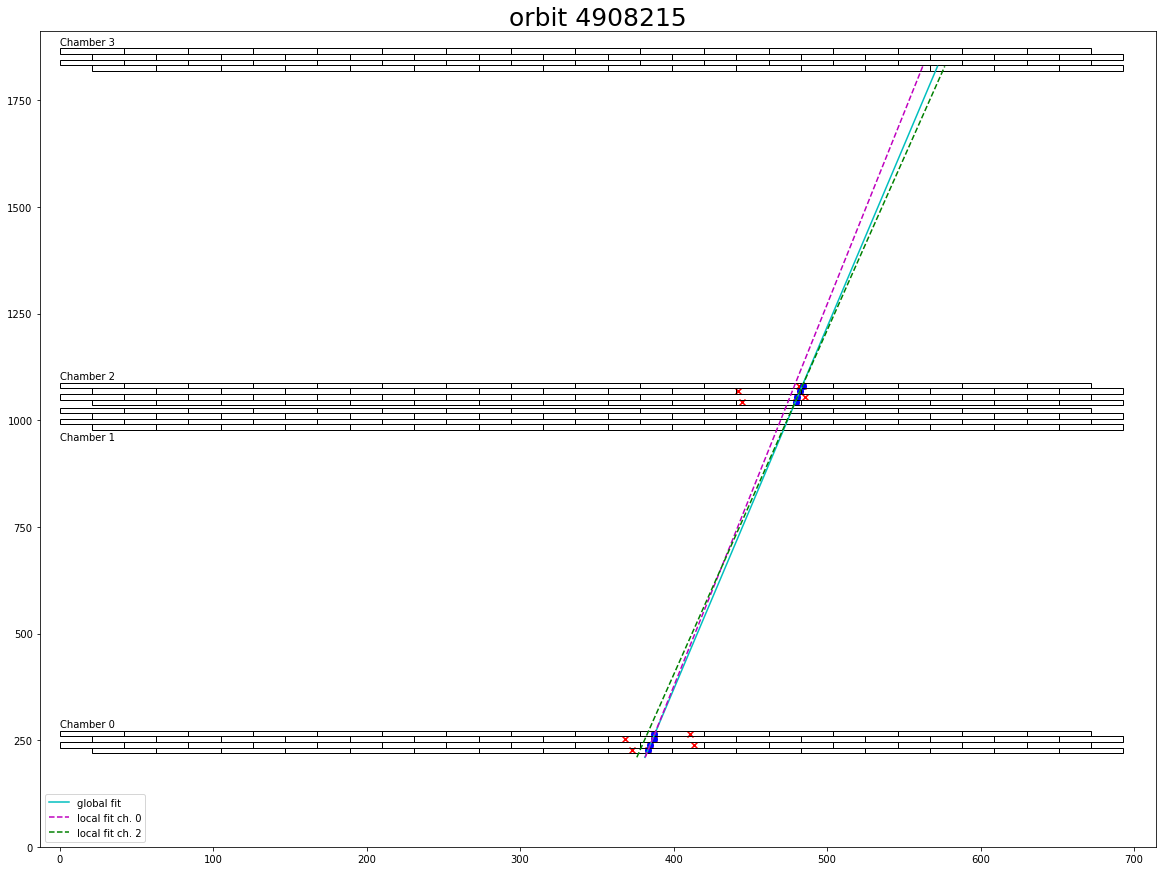

In [145]:
tmp = df7[df7.orbit == d.index[d.abs().argmin()]]
plot_global_fit_chambers(tmp);

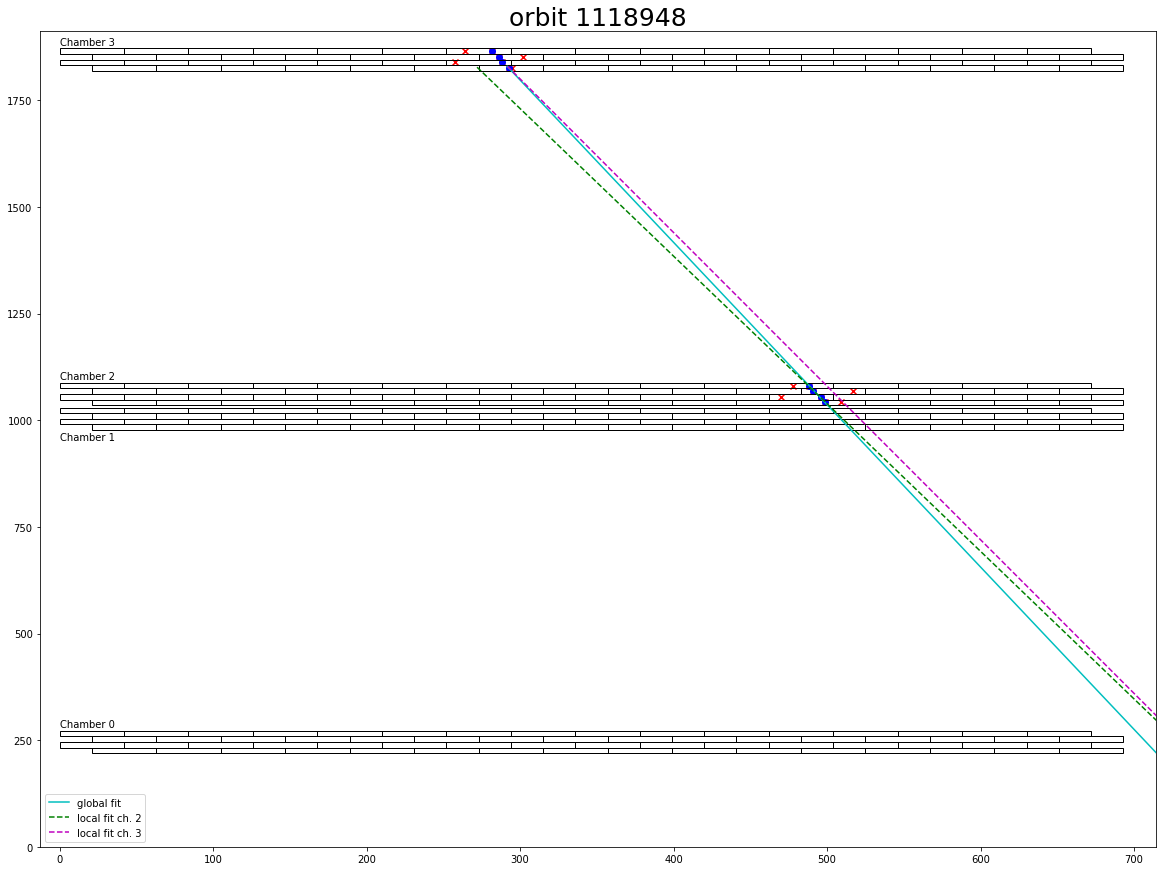

In [146]:
tmp = df7[df7.orbit == df7.orbit.unique()[0]]
plot_global_fit_chambers(tmp);

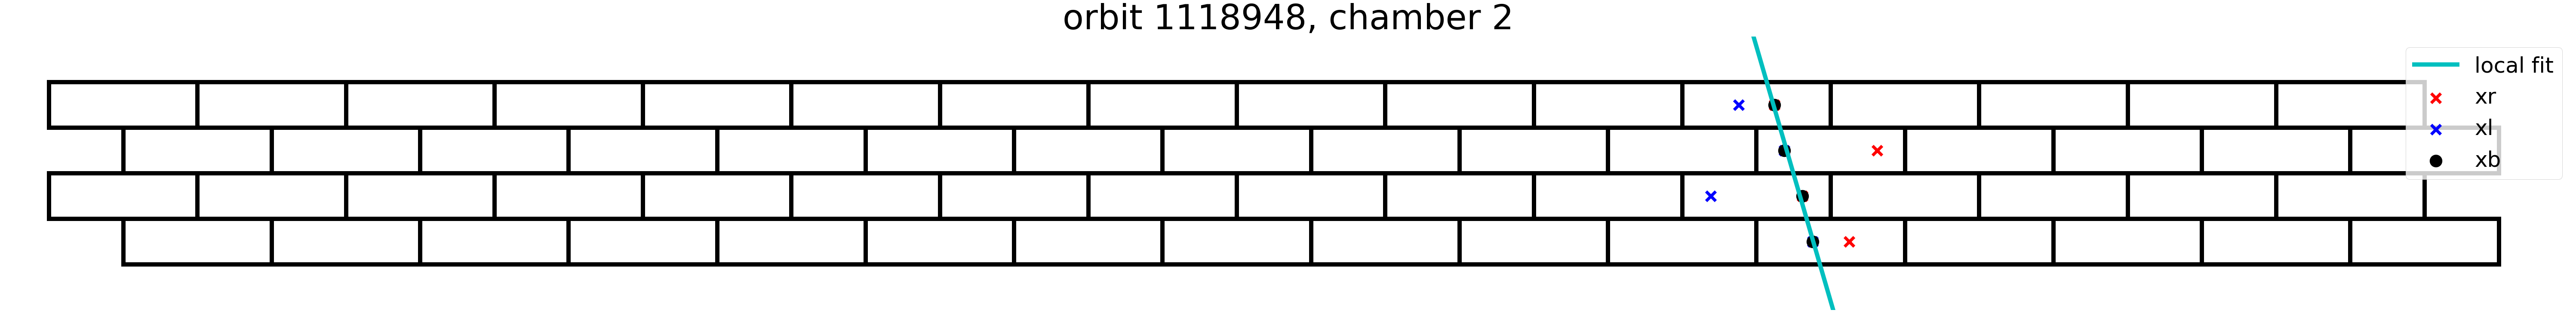

In [147]:
def plot_local_fit(event, plot_fit = True) :
    fig, ax = plt.subplots(figsize = (1.5*4.2*17, 1.5*1.3*6)) # nrows = len(event.chamber.unique()), ncols = 1,

    # dimensions of one cell
    dx = 42
    dz = 13


    # coordinate del punto in basso a sinistra
    x2 = x4 = np.arange(16)*dx 
    x1 = x3 = x2 + dx/2 # queste 3 righe rappresentano i layers, non le camere
    [z1, z2, z3, z4] = np.arange(4)*dz  

    X = np.vstack((x1, x2, x3, x4))
    Z = np.array([z1, z2, z3, z4])

    #for n, ch in enumerate(event.chamber.unique()) : # le camere disponibili
    
    # detector
    ax.set_xlim(-13, 42*16 + 42)
    ax.set_ylim(-13, (13*4 + 13))
    for i in range(4) : # i 4 layer in una camera
        for j in range(16) : # le 16 celle in un dato layer
            ax.add_patch(Rectangle((X[i][j], Z[i]), dx, dz, linewidth = 10, edgecolor = 'black', facecolor = 'none')) # , linewidth = 10
            ax.axis('off')

    # xr = event[event.chamber == ch].xr
    # xl = event[event.chamber == ch].xl
    # z = event[event.chamber == ch].z - z_offset[ch]
    # xb = event[event.chamber == ch].xb
    xr, xl, z = event.xr, event.xl, event.z.to_numpy() - z_offset[event.chamber.iloc[0]]

    ax.scatter(xr, z, marker = "x", c = "red" , s = 500, linewidth = 7, label = 'xr') #
    ax.scatter(xl, z, marker = "x", c = "blue" , s = 500, linewidth = 7, label = 'xl') #
    if plot_fit :
        xb = event.xb.to_numpy()
        ax.scatter(xb, z, c = "black", s = 500, linewidth = 7, label = 'xb') #

        # fit locale
        slope, intercept = fit(z, xb)
        m, q = 1/slope, -intercept/slope

        def xplot(m, q) :
            zmin, zmax = -20, 13*4+20
            return np.array([(zmin - q)/m, (zmax-q)/m]) # invertendo z = mx+q trovo (z-q)/m = x, da cui le x corrispondenti a zmin e zmax

        ax.plot(xplot(m, q), m*xplot(m, q) + q, 'c', label = 'local fit', linewidth = 10)

    ax.set_title(f'orbit {event.orbit.iloc[0]}, chamber {event.chamber.iloc[0]}', fontsize = 80)
    ax.legend(loc = 'upper right', fontsize = 50)
    return ax

tmp = df7[df7.orbit == df7.orbit.unique()[0]]
plot_local_fit(tmp[tmp.chamber == tmp.chamber.unique()[0]]);